# TRAPPIST-1 Follow-up

In this tutorial, we will use the discovery data for the TRAPPIST-1 planetary system to illustrate how to use `transitforecast` to prioritize follow-up windows.

In [1]:
# Import some packages we know we're going to need
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib notebook

## Load the data

First, let's load in the dataset.

In [3]:
d = pd.read_csv('trappist1_lc_flat.csv')
d

time      flux  flux_err     trend
0      2.457283e+06  0.996553       NaN  0.999392
1      2.457283e+06  0.997024       NaN  0.999422
2      2.457283e+06  0.995654       NaN  0.999356
3      2.457283e+06  1.000173       NaN  0.999391
4      2.457283e+06  1.001591       NaN  0.999457
...             ...       ...       ...       ...
12507  2.457390e+06  0.997818       NaN  1.000000
12508  2.457390e+06  0.994002       NaN  1.000000
12509  2.457390e+06  1.005075       NaN  1.000000
12510  2.457390e+06  0.994781       NaN  1.000000
12511  2.457390e+06  1.001893       NaN  1.000000

[12512 rows x 4 columns]

No flux uncertainties are provided, so we'll use the median absolute deviation of the fluxes to estimate them.

In [4]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(d.flux, scale='normal')
d.flux_err = mad
d

time      flux  flux_err     trend
0      2.457283e+06  0.996553  0.004316  0.999392
1      2.457283e+06  0.997024  0.004316  0.999422
2      2.457283e+06  0.995654  0.004316  0.999356
3      2.457283e+06  1.000173  0.004316  0.999391
4      2.457283e+06  1.001591  0.004316  0.999457
...             ...       ...       ...       ...
12507  2.457390e+06  0.997818  0.004316  1.000000
12508  2.457390e+06  0.994002  0.004316  1.000000
12509  2.457390e+06  1.005075  0.004316  1.000000
12510  2.457390e+06  0.994781  0.004316  1.000000
12511  2.457390e+06  1.001893  0.004316  1.000000

[12512 rows x 4 columns]

We could work with the data in a `pandas.DataFrame` at this point, but we'll use a `lightkurve.LightCurve` to hold the data instead so that we can take advantage of some additional functionality of that class.

In [5]:
lc = lk.LightCurve(
    time=d.time,
    flux=d.flux,
    flux_err=d.flux_err
)
lc

For example, let's take a look at the data.

<IPython.core.display.Javascript object>


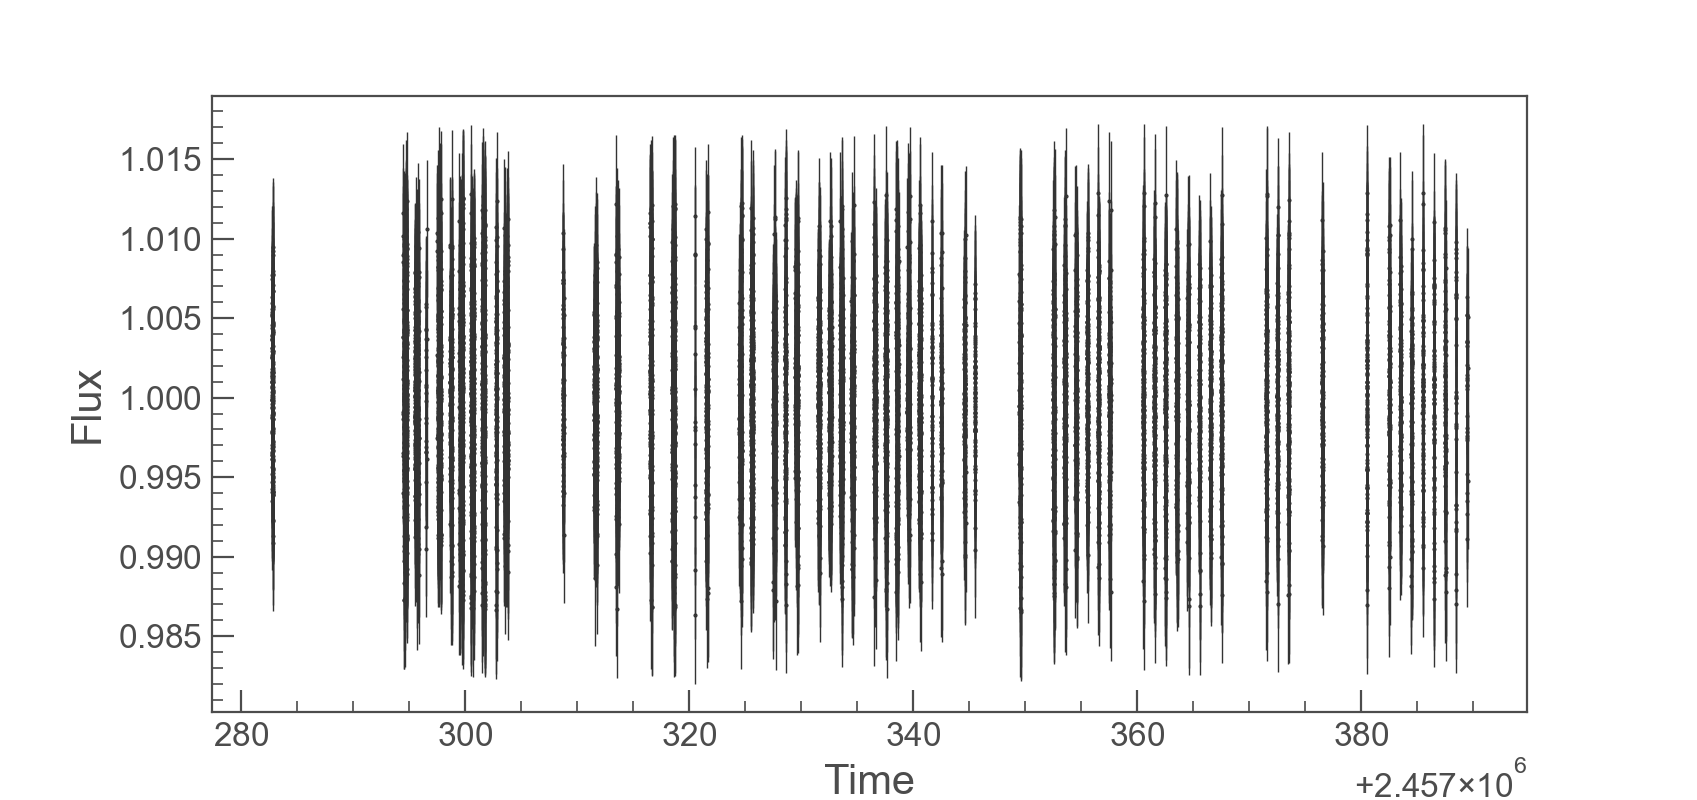

In [6]:
lc.errorbar(marker='.');

And let's phase-fold the light curve on the top `t0` and `period` returned by a `transitleastsquares` search.

<IPython.core.display.Javascript object>


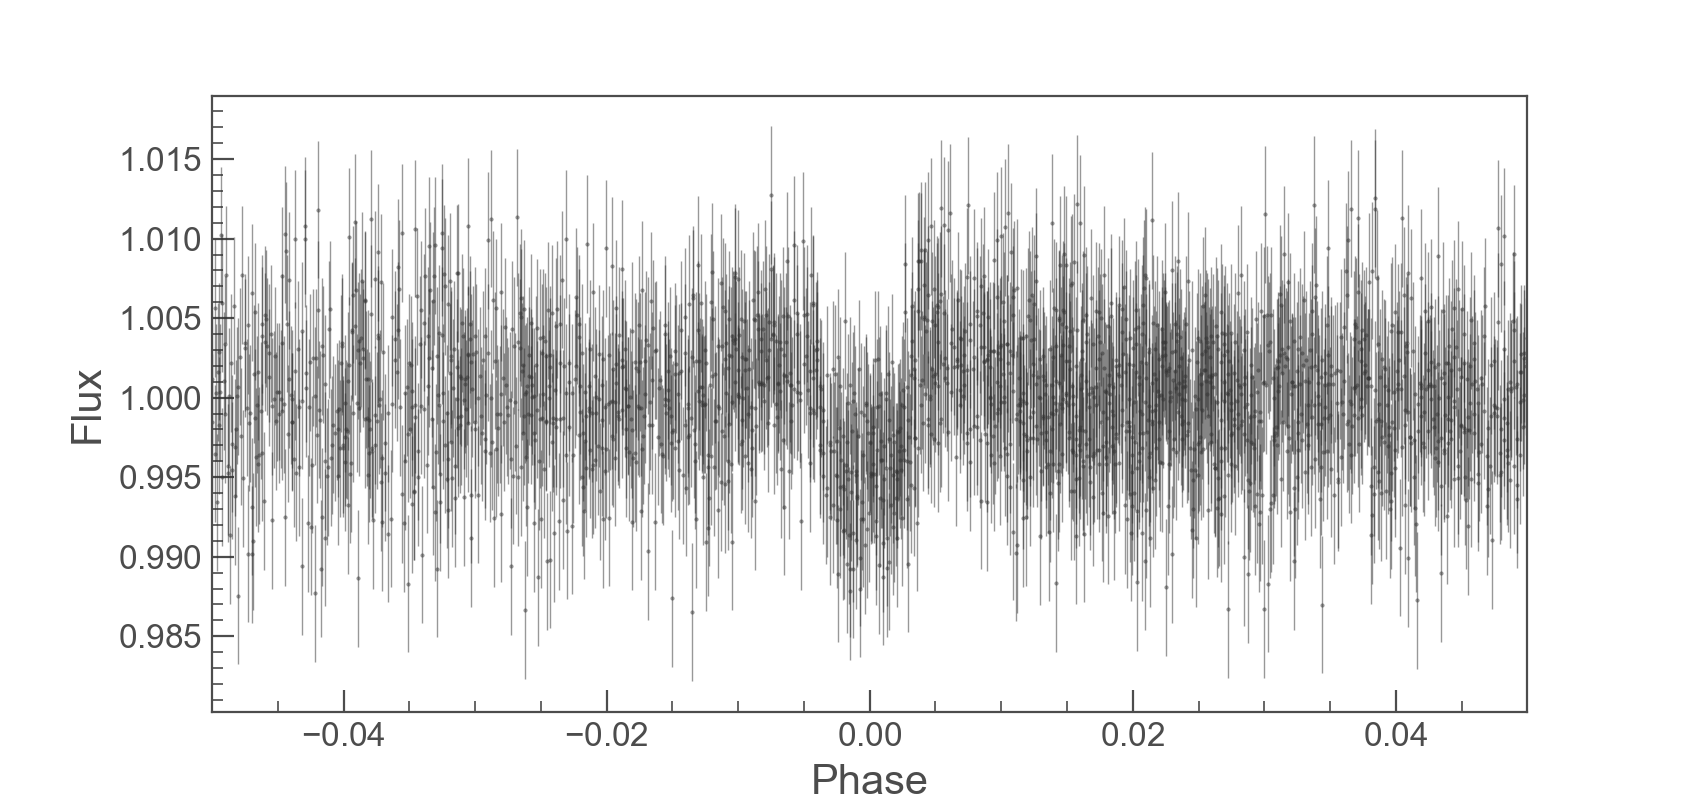

In [7]:
pri_t0 = 2457283.235
pri_p = 3.02164958340094
pri_rprs = 0.06027618

ax = lc.fold(t0=pri_t0, period=pri_p).errorbar(marker='.', alpha=0.5)
ax.set_xlim(-0.05, 0.05);

In fact, let's look at the top 5 scenarios returned by a `tls` search.

<IPython.core.display.Javascript object>


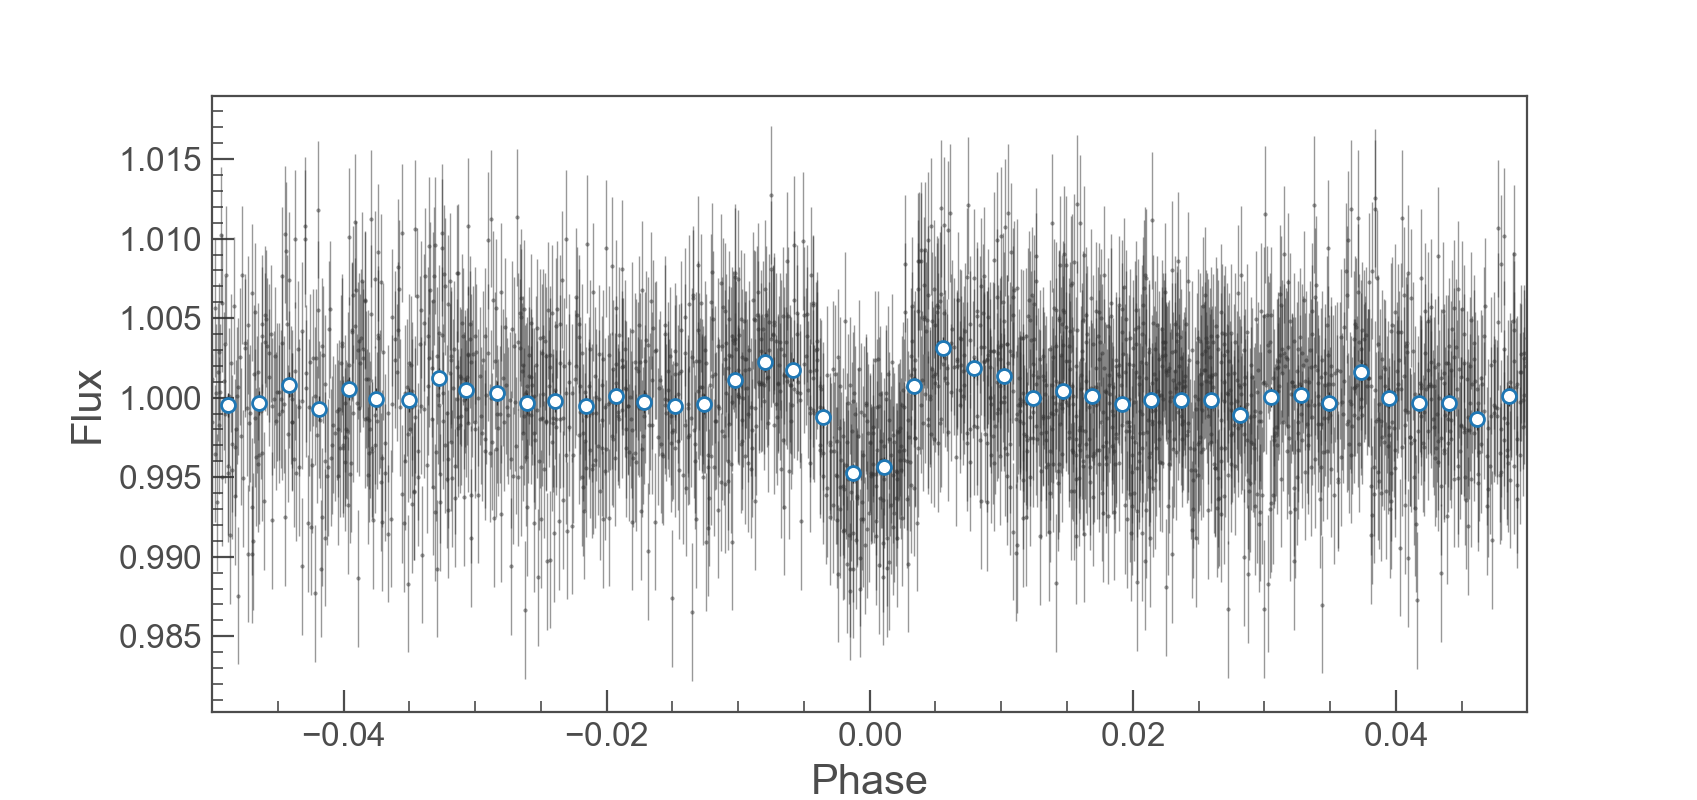

<IPython.core.display.Javascript object>


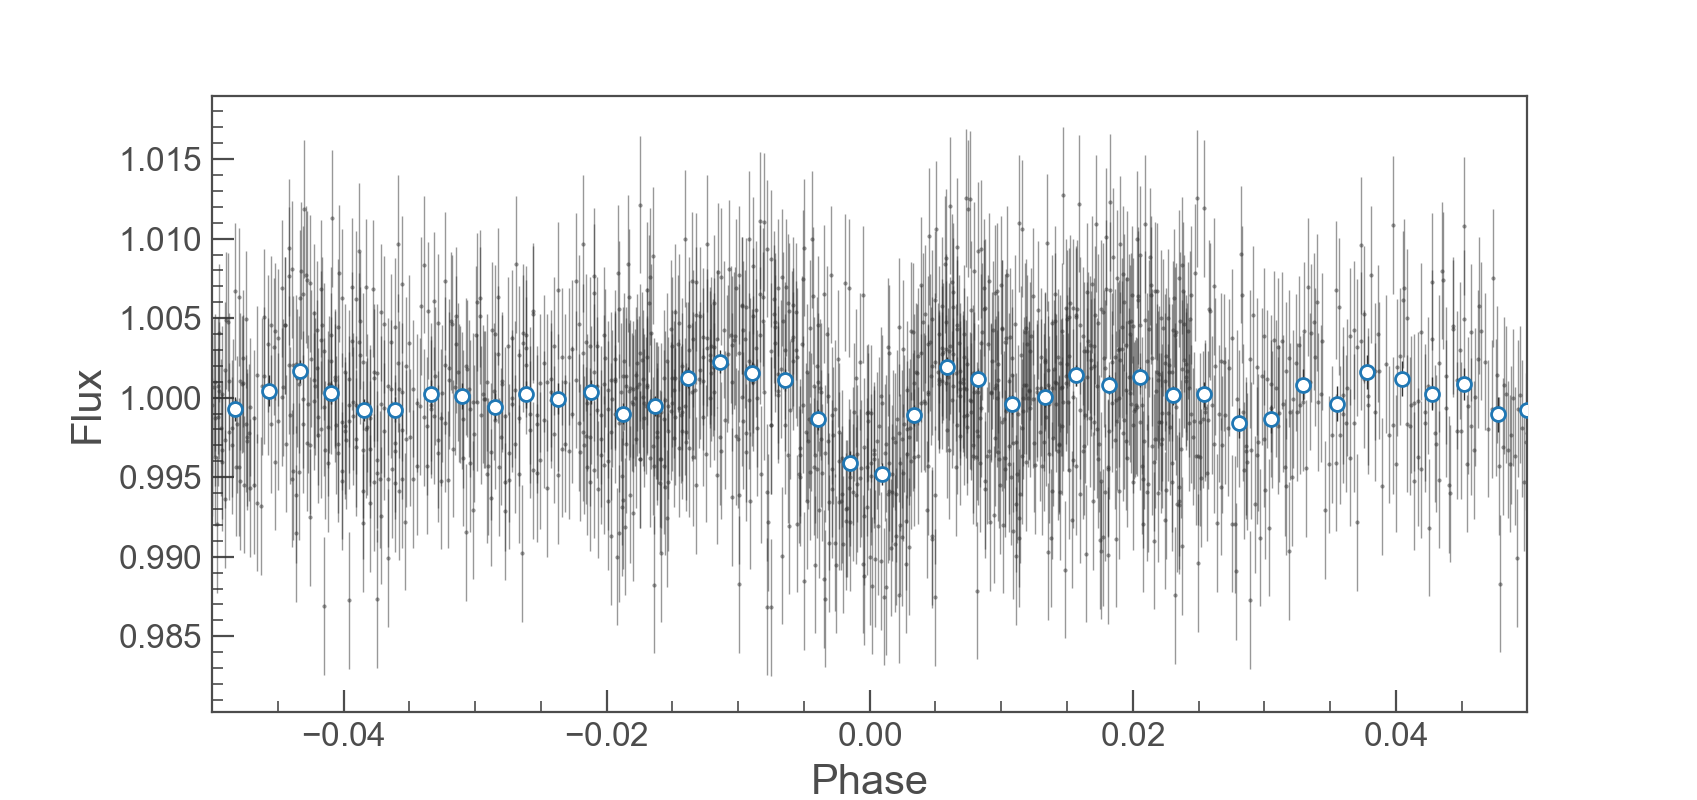

<IPython.core.display.Javascript object>


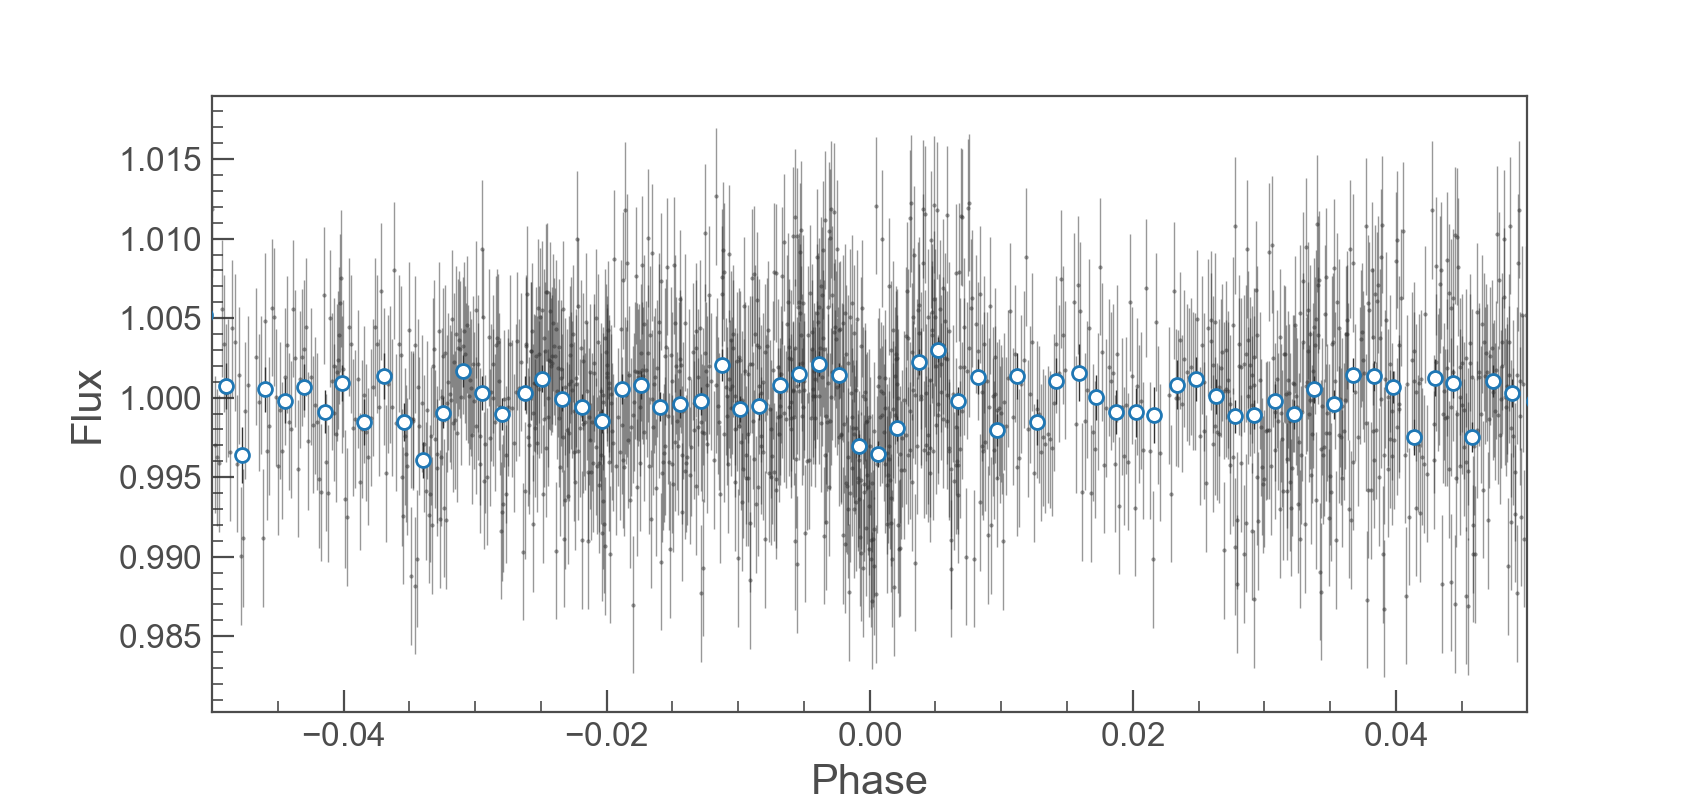

<IPython.core.display.Javascript object>


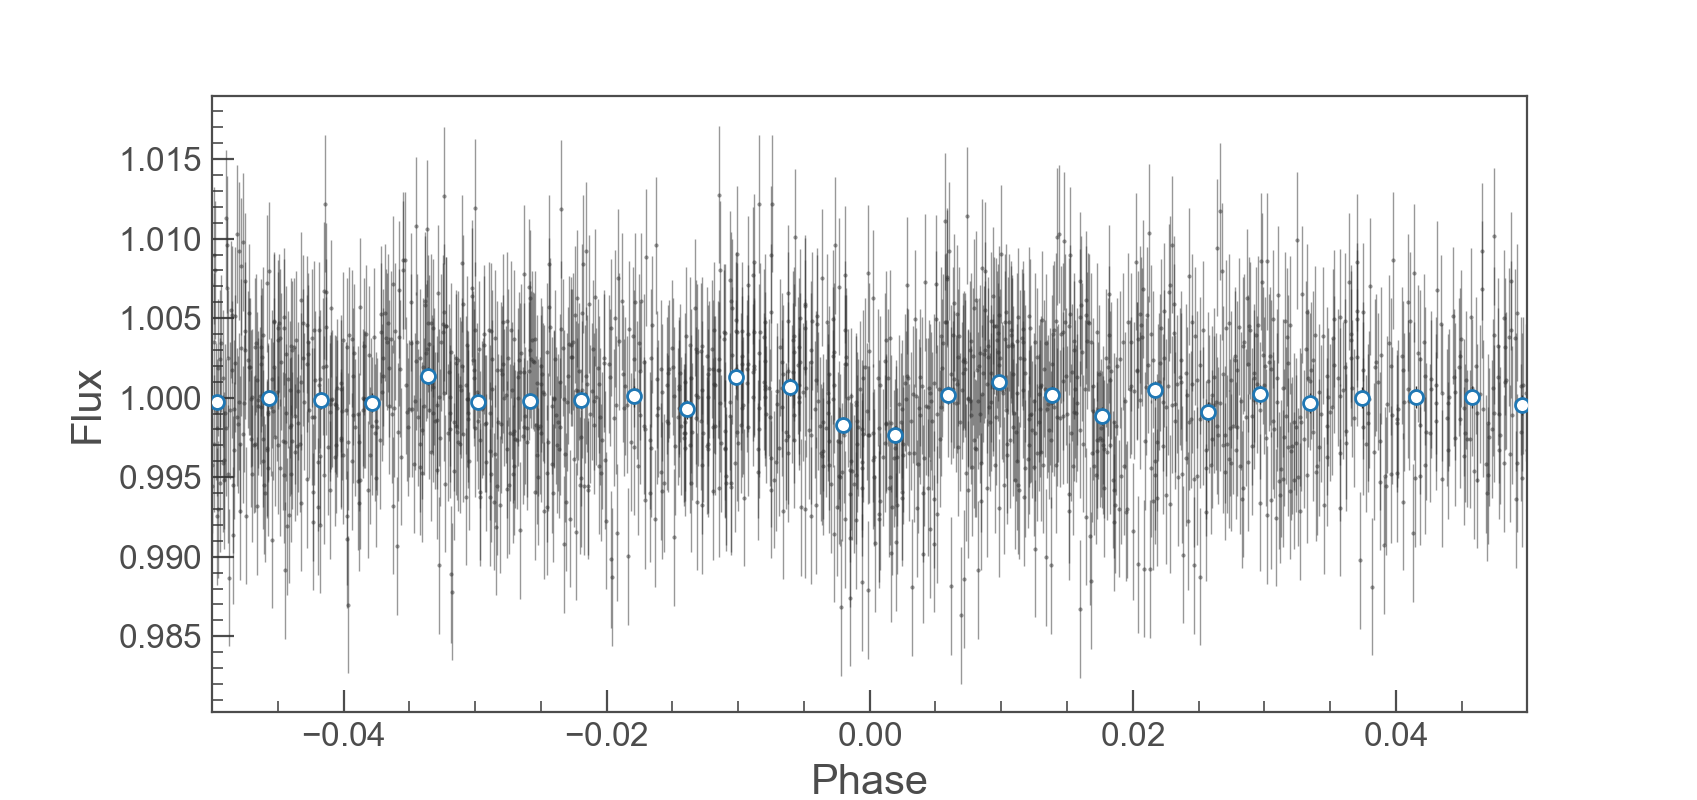

<IPython.core.display.Javascript object>


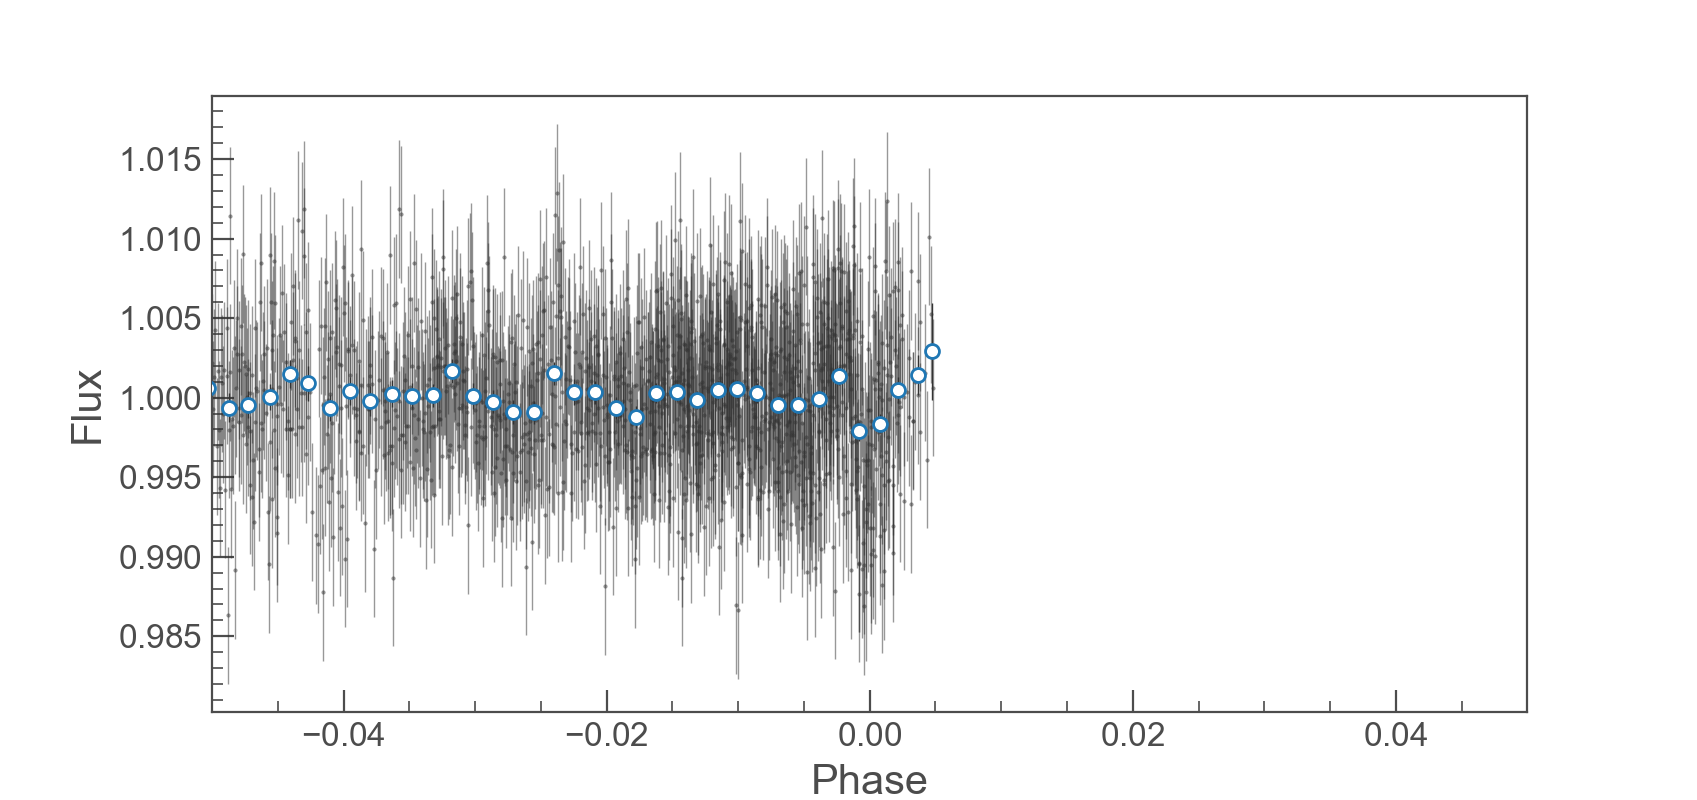

In [8]:
pri_t0s = [2457283.235, 2457282.803, 2457283.147, 2457283.696, 2457284.860] 
pri_ps = [3.02164958340094, 2.825653469, 4.615432934, 1.753996325, 4.487644045]
pri_rprss = [0.06027618, 0.059468536, 0.050877637, 0.042044128, 0.048652169]

for pri_t0, pri_p, pri_rprs in zip(pri_t0s, pri_ps, pri_rprss):
    ax = lc.fold(t0=pri_t0, period=pri_p).errorbar(marker='.', alpha=0.5)
    
    # Bin the light curve
    bins = int(pri_p/(10/(24*60)))  # 10-min bins
    binned_lc = lc.fold(t0=pri_t0, period=pri_p).bin(bins=bins)
    binned_lc.errorbar(ax=ax, marker='o', ms=5, color='C0', mfc='white', alpha=1, zorder=10)
    ax.set_xlim(-0.05, 0.05);

## MCMC Fit to Scenarios

Cool, now we'll use `transitforecast` to explore each of these scenarios with a MCMC. The goal is not to converge on a fit for each, but to explore the range of possible transit scenarios suggested by this dataset, using these TLS results as a jumping-off point.

We will generate a forecasted transit model for every accepted step in the MCMC, so we need to define our window of interest first.
We can do this easily with a convenience function from `transitforecast`.

In [9]:
import transitforecast as tf

help(tf.get_forecast_window)

Help on function get_forecast_window in module transitforecast.forecast:

get_forecast_window(size=<Quantity 30. d>, cadence=<Quantity 2. min>, start=None)
    Get an array of times in JD to forecast transits.
    
    Defaults to an array covering the next 30 days at 2-min cadence.
    
    Parameters
    ----------
    size : float or `~astropy.units.Quantity`
        Size of the forecast window. Defaults to days if unit not specified.
    
    cadence : float or `~astropy.units.Quantity`
        Cadence of the times in the forecast window. Defaults to 2-min if
        unit not specfied.
    
    start : `~astropy.time.Time`
        Start of the forecast window. `None` defaults to now.
    
    Returns
    -------
    tforecast : `~numpy.ndarray`
        Array of times in JD.




>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


The default behavior of `tf.get_forecast_window()` is to provide an array of times covering the next 30 days at 2-min cadence.
For this example, let's get a custom array covering the 6 months following the last TRAPPIST observation at 2-min cadence.

In [10]:
from astropy import units
from astropy.time import Time

size = 0.5*units.yr
cadence = 2*units.min
start = Time(lc.time.max(), format='jd')
tforecast = tf.get_forecast_window(size=size, cadence=cadence, start=start)
tforecast

array([2457389.54448   , 2457389.54586889, 2457389.54725778, ...,
       2457572.16531333, 2457572.16670222, 2457572.16809111])

We also need priors for the stellar mass and radius. We can get these by querying the TESS Input Cataog via a convenience function provided by the `transitleastsquares` package and a wrapper function from `transitforecast`.

In [11]:
import transitforecast as tf
import transitleastsquares as tls

tic_id = 278892590

# Wrapper for the tls.catalog_info() function
pri_m_star, pri_r_star = tf.get_priors_from_tic(tic_id)

This returns a pair of arrays with the mean and standard deviations of the stellar mass and radius estimates, respectively.

In [12]:
# (mean, std)
print(pri_m_star)
print(pri_r_star)

[0.0907782 0.0200069]
[0.114827   0.00335728]


Okay, now we have everything we need for the MCMC sampling.
We'll iterate through the interesting ephemerides we have for this dataset and do the following for each:
1. Build a model for the light curve and identify the MAP solution with `tf.build_model()`.
2. Plot the MAP solution with `tf.plot_map_soln()`.
3. Sample from the model with `tf.sample_from_model()`.
4. Plot the median posterior model with `tf.plot_posterior_model()`.
5. Save the `model`, `map_soln`, and `trace` in a list for further comparison.

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple s

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple s

optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 49852.04266252143 -> 49852.04266252146
optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple s

optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49852.04266252152 -> 49852.04266252152


<IPython.core.display.Javascript object>


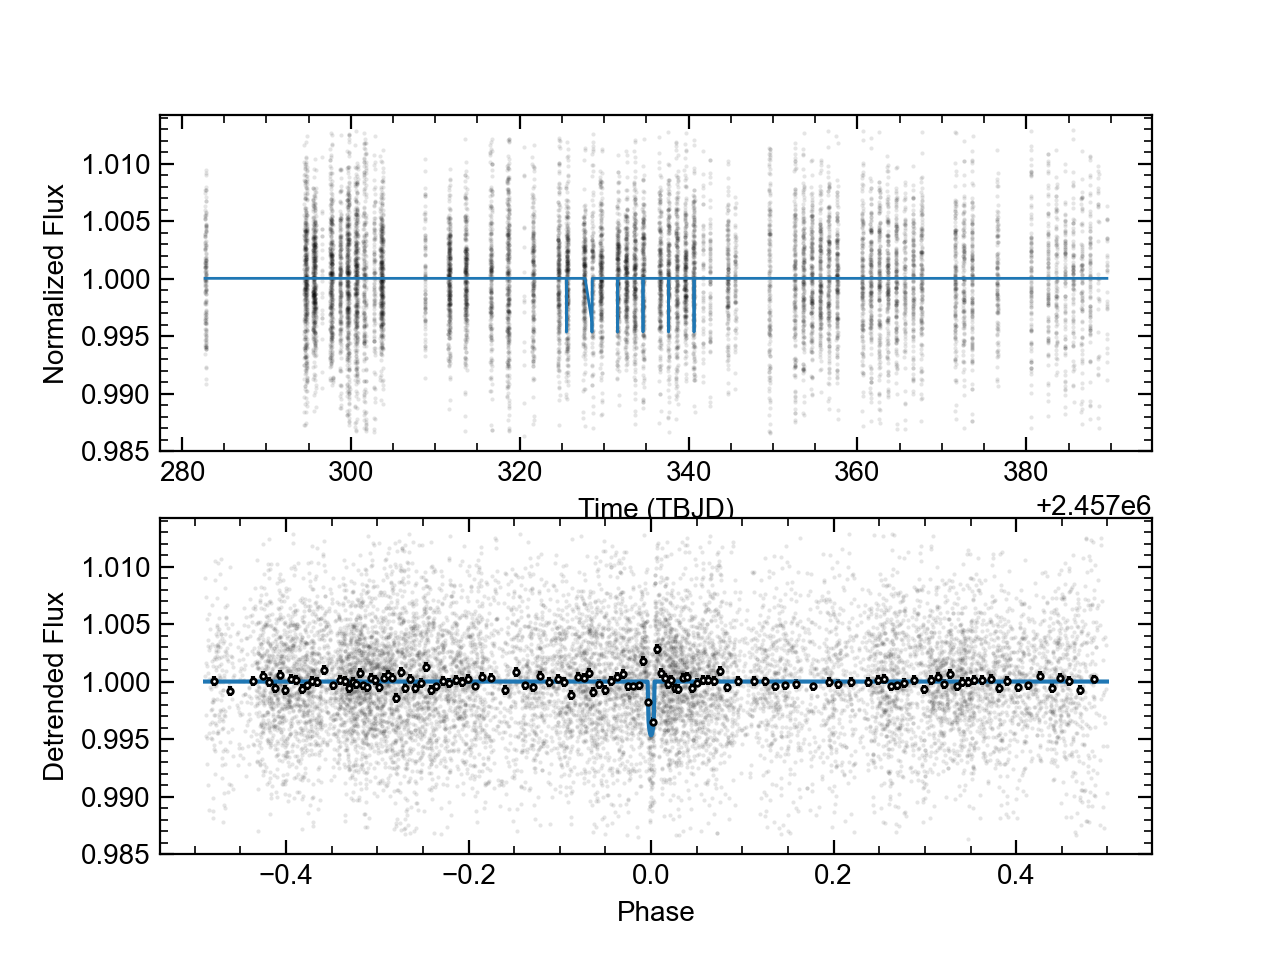

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and le

<IPython.core.display.Javascript object>


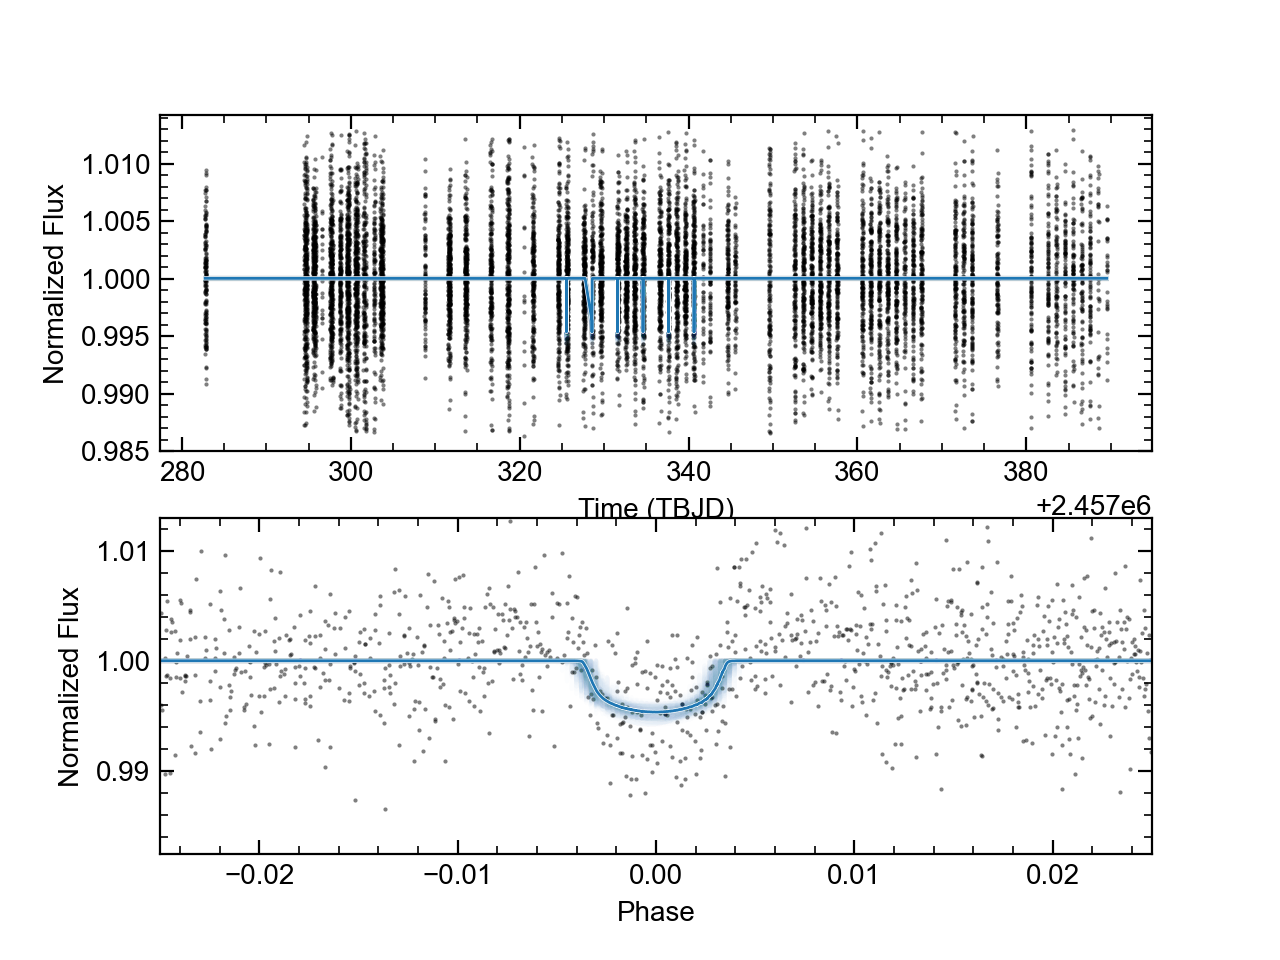

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple s

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.802753098025


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.802753098025


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.802753098025


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49834.802753098025 -> 49834.80275309803


<IPython.core.display.Javascript object>


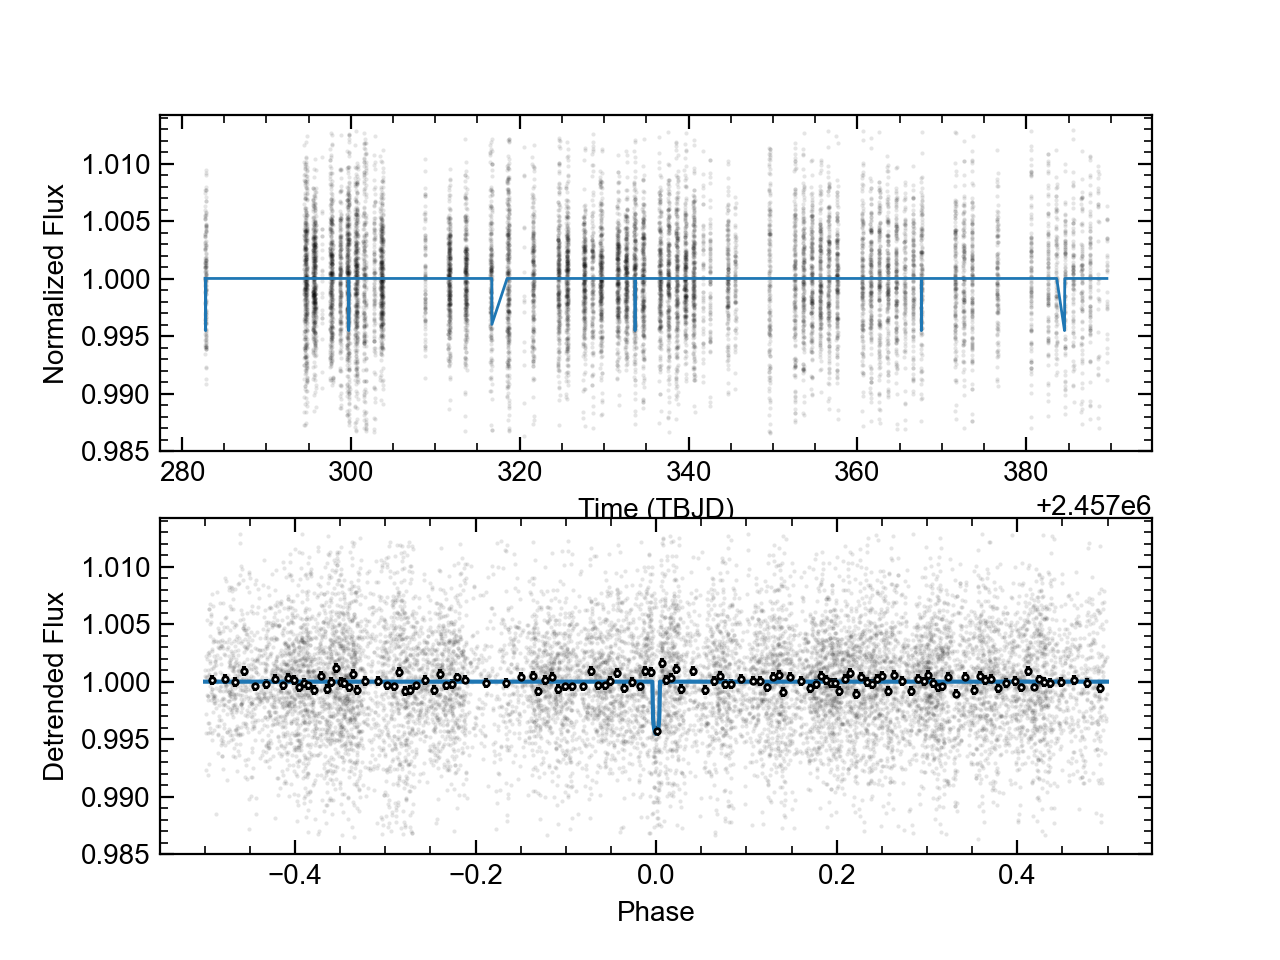

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 120 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

<IPython.core.display.Javascript object>


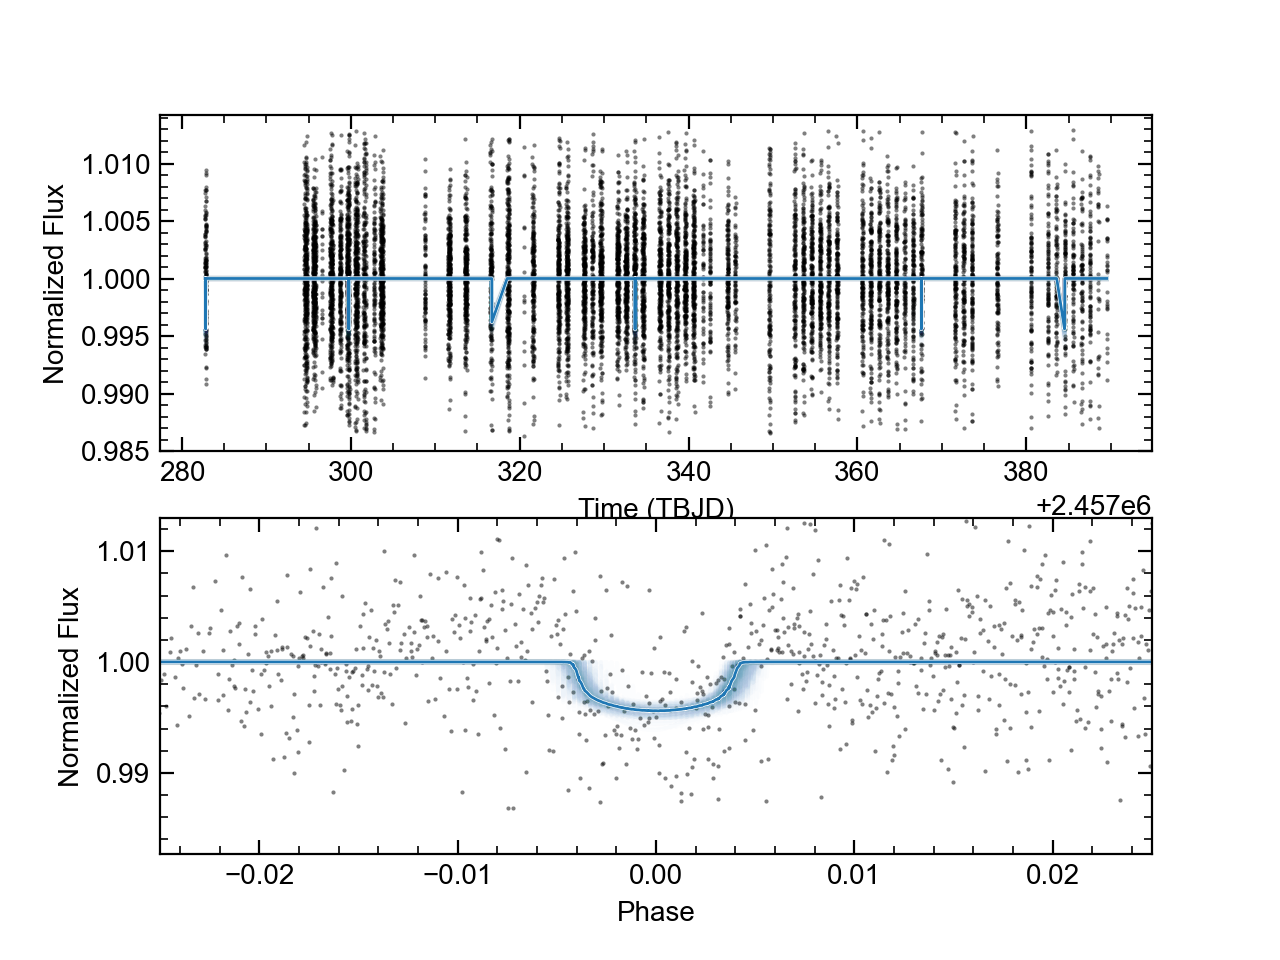

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple s

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.4685757042 -> 49810.4685757042


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.4685757042 -> 49810.46857570421


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.46857570421 -> 49810.46857570422


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49810.46857570422 -> 49810.46857570422


<IPython.core.display.Javascript object>


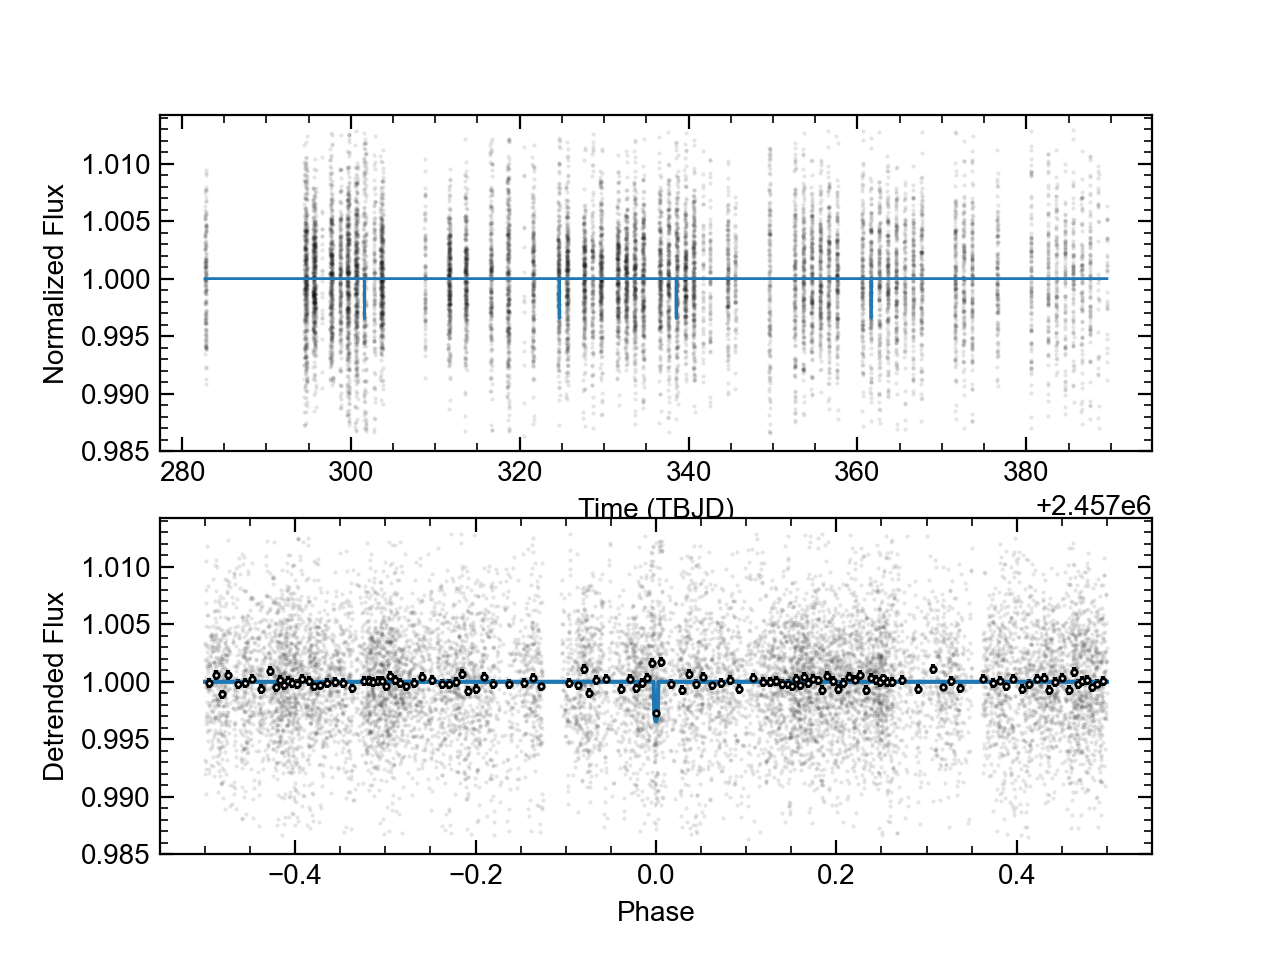

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 114 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.835729996453063, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8868024485937542, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8571163850542007, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The

<IPython.core.display.Javascript object>


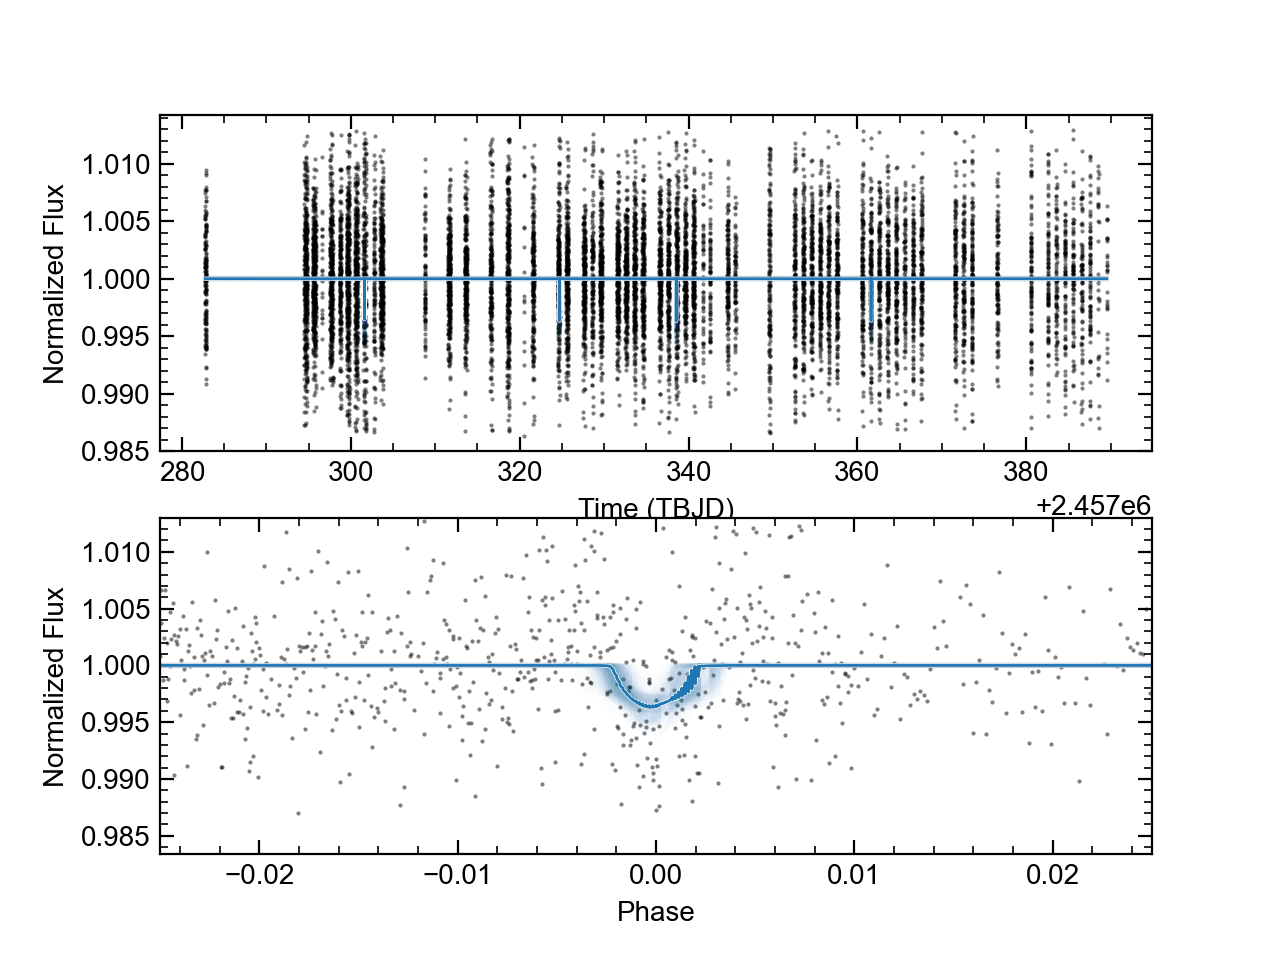

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple s

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.65949582547 -> 49804.65949582547


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.65949582547 -> 49804.65949582547


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.65949582547 -> 49804.659495825494


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49804.659495825494 -> 49804.659495825494


<IPython.core.display.Javascript object>


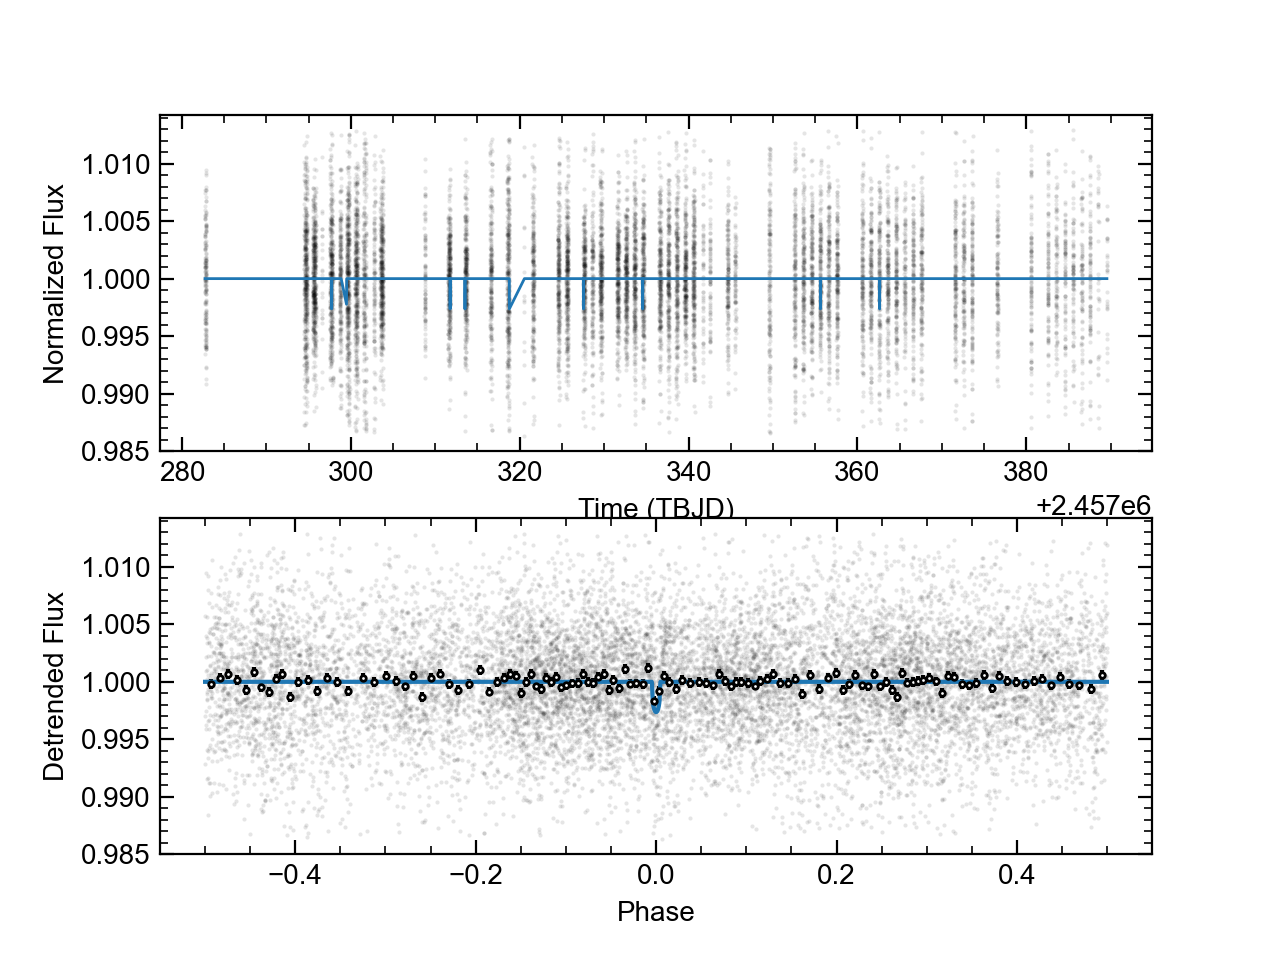

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 120 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8929449531279622, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/pymc3/stats/__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sur

<IPython.core.display.Javascript object>


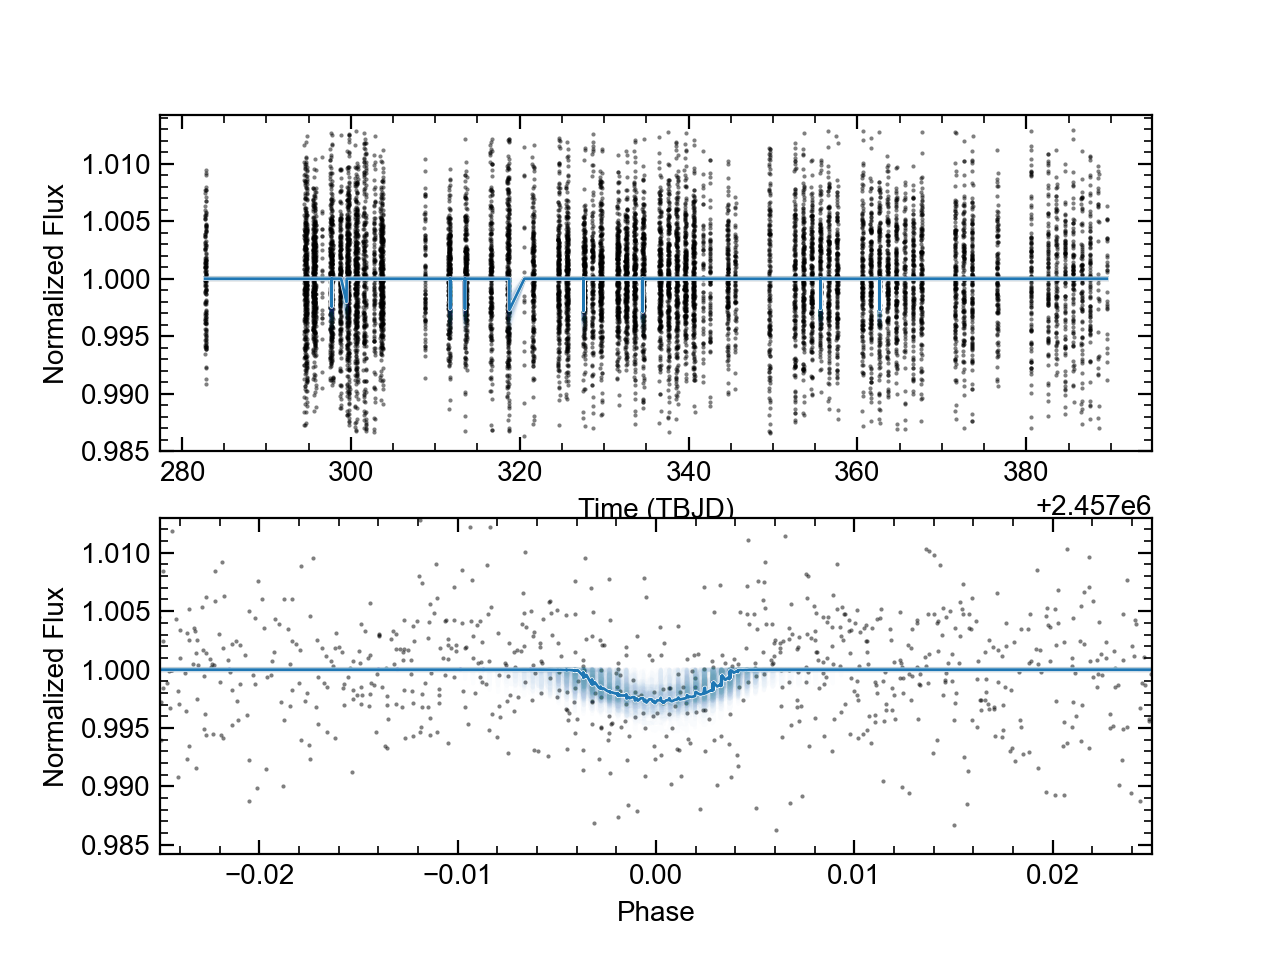

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple s

optimizing logp for variables: [r, t0, logperiod, f0]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171782 -> 49788.99616171782


optimizing logp for variables: [m_star, r_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171782 -> 49788.99616171783


optimizing logp for variables: [logperiod, r_star, m_star, b, r]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171783 -> 49788.99616171783


optimizing logp for variables: [f0, t0, logperiod, b, r, u, r_star, m_star]


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 49788.99616171783 -> 49788.99616171783


<IPython.core.display.Javascript object>


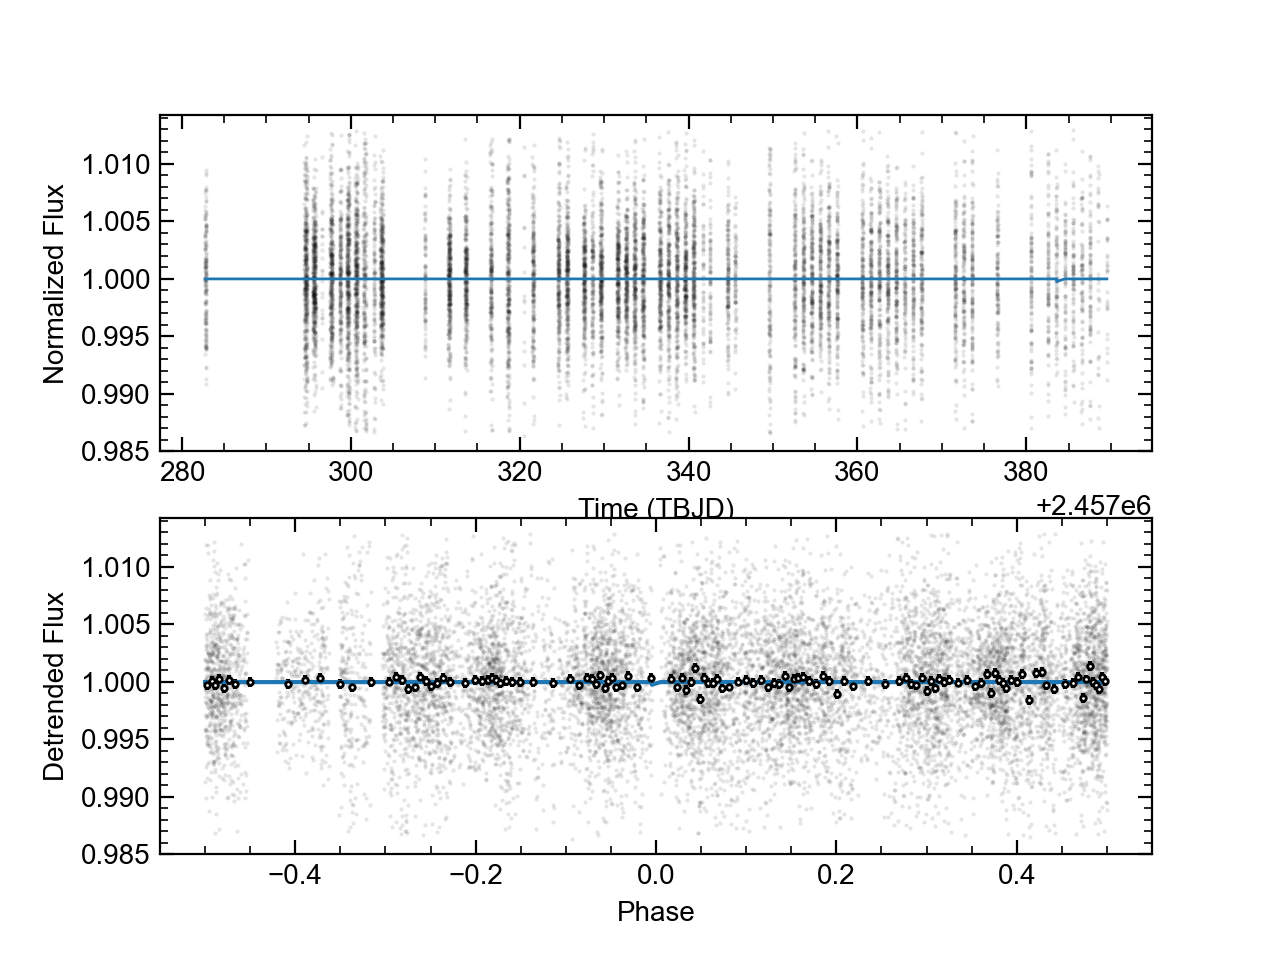

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f0, t0, logperiod, b, r, u, r_star, m_star]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 231 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6449710210650814, but should be close to 0.95. Try to increase the number of tuning steps.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5991014043667605, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894854918025987, but should be close to 0.95. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7407748929026065, but should be close to 0.95. Try to increase the number of tuning steps.
There were 382 divergences after t

<IPython.core.display.Javascript object>


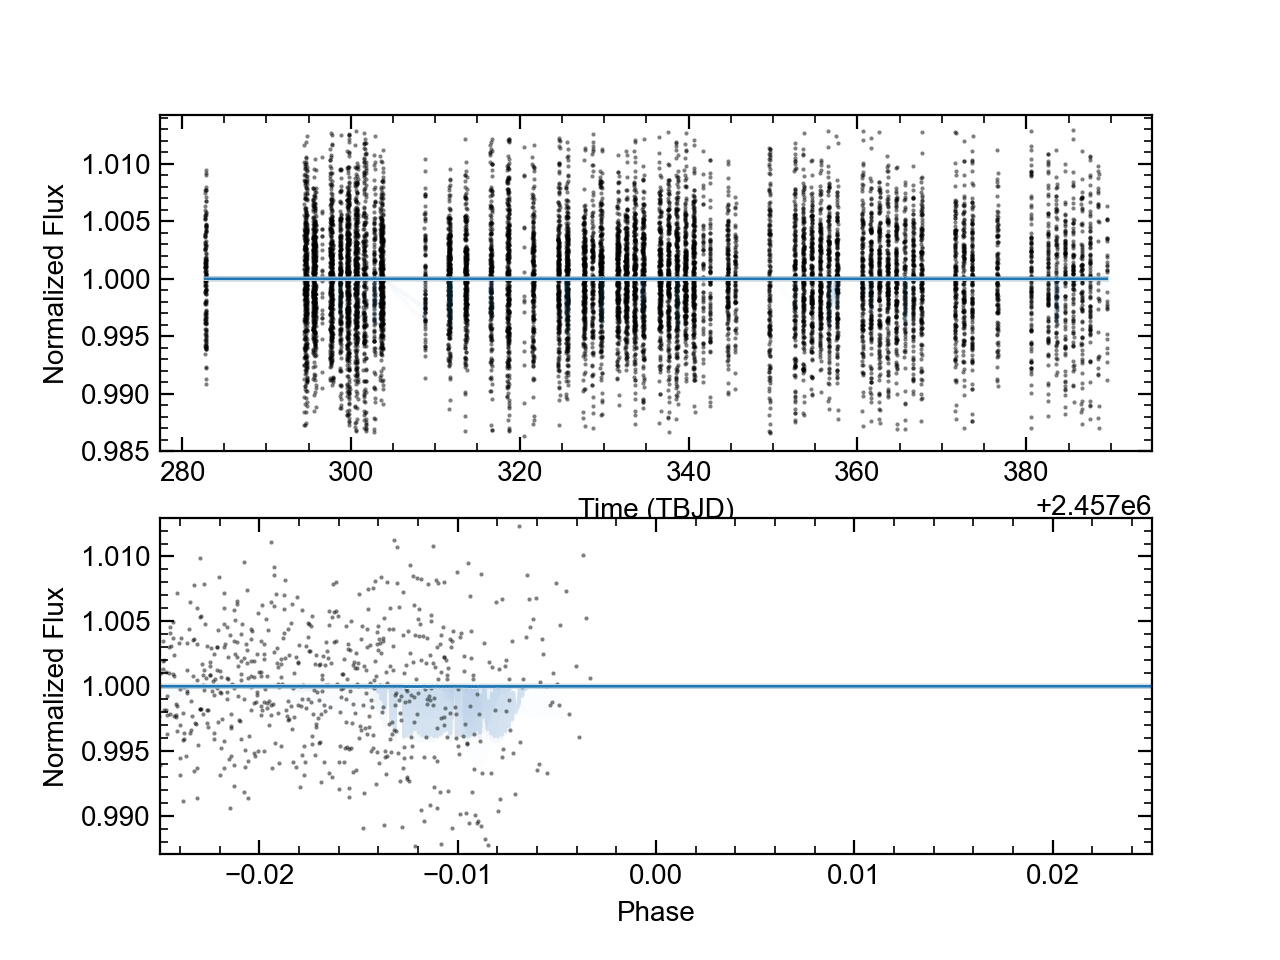

In [13]:
models = []
map_solns = []
traces = []
for i, (pri_t0, pri_p, pri_rprs) in enumerate(zip(pri_t0s, pri_ps, pri_rprss)):
    model, map_soln = tf.build_model(
        lc, pri_t0, pri_p, pri_rprs, pri_m_star, pri_r_star, tforecast, verbose=True
    )
    tf.plot_map_soln(lc, map_soln)
    trace = tf.sample_from_model(model, map_soln)
    fig, axes =  tf.plot_posterior_model(lc, trace)

    models.append(model)
    map_solns.append(map_soln)
    traces.append(trace)

Now we have a list, `traces`, which includes the results of the MCMC sampling of each of these scenarios.

Let's take a quick look at the posteriors for the most interesting parameters for follow up: `t0`, `period`, and `r`.

In [14]:
import pymc3 as pm

summaries = []
for i, trace in enumerate(traces):
    summary = pm.summary(
        trace,
        var_names=['t0', 'period', 'r'],
        round_to=8
    )
    print(f'Scenario {i+1}')
    print(summary)
    summaries.append(summary)

/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 1
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457283e+06  0.006130  2.457283e+06  2.457283e+06   0.002170   
period  3.021900e+00  0.000371  3.021189e+00  3.022556e+00   0.000006   
r       6.636988e-02  0.004751  5.754445e-02  7.519968e-02   0.000090   

         mcse_sd     ess_mean       ess_sd     ess_bulk     ess_tail     r_hat  
t0      0.001594     7.982763     7.982763  3782.449004  3211.950960  1.003251  
period  0.000004  3699.406842  3699.406842  3735.527685  3376.809745  1.003189  
r       0.000064  2804.145306  2785.300147  2858.179609  2529.392641  1.001836  


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 2
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457283e+06  0.001135  2.457283e+06  2.457283e+06   0.000398   
period  2.825560e+00  0.000064  2.825443e+00  2.825681e+00   0.000001   
r       6.180203e-02  0.004867  5.274281e-02  7.083489e-02   0.000106   

             mcse_sd     ess_mean       ess_sd     ess_bulk     ess_tail  \
t0      2.921500e-04     8.128523     8.128523  2910.099836  2850.481533   
period  8.700000e-07  2694.097685  2694.097685  2684.186370  2674.081863   
r       7.484000e-05  2114.785637  2114.785637  2081.461075  2432.477289   

           r_hat  
t0      1.000378  
period  1.001168  
r       1.002155  


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 3
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457283e+06  0.003175  2.457283e+06  2.457283e+06   0.001115   
period  4.615497e+00  0.000268  4.614959e+00  4.615942e+00   0.000008   
r       2.061062e-01  0.254622  4.119056e-02  7.779444e-01   0.035907   

         mcse_sd     ess_mean       ess_sd     ess_bulk     ess_tail     r_hat  
t0      0.000821     8.107837     8.068295   339.181152  1850.653551  1.023784  
period  0.000006  1145.504579  1145.504579  1311.714000  1736.615160  1.007525  
r       0.025539    50.285395    50.285395    61.886751   307.161734  1.100061  


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 4
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457284e+06  0.003779  2.457284e+06  2.457284e+06   0.001316   
period  1.753963e+00  0.000119  1.753764e+00  1.754184e+00   0.000004   
r       2.350924e-01  0.294192  3.056319e-02  8.945339e-01   0.025752   

         mcse_sd    ess_mean      ess_sd    ess_bulk     ess_tail     r_hat  
t0      0.000966    8.242720    8.233175  926.632314  1633.786034  1.007263  
period  0.000003  957.590559  957.590559  976.871614  1499.784872  1.006901  
r       0.018251  130.504450  130.504450  161.453022   209.291892  1.042530  


/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/brackham/anaconda3/envs/transitforecast-dev/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Scenario 5
                mean        sd        hdi_3%       hdi_97%  mcse_mean  \
t0      2.457285e+06  1.255847  2.457283e+06  2.457288e+06   0.375198   
period  4.471602e+00  0.109068  4.285688e+00  4.586391e+00   0.032243   
r       2.977569e-01  0.262146  4.522700e-04  7.656310e-01   0.049307   

         mcse_sd   ess_mean     ess_sd   ess_bulk    ess_tail     r_hat  
t0      0.272536  11.203472  11.203472  10.425092   11.549767  2.188784  
period  0.023491  11.442969  11.364793  10.731541   15.492436  2.121203  
r       0.035232  28.266135  28.266135  33.585821  212.007552  1.170005  


Judging by the $\hat{R}$ values, Scenarios 1 and 2 settled into relatively more stable solutions, while the rest were sampling from "all over the place."

## Calculating the Transit Forecast

Let's take a look at the mean transit model forecasts for each scenario.

In [15]:
forecasts = [
    tf.transit_forecast(trace) for trace in traces
]

<IPython.core.display.Javascript object>


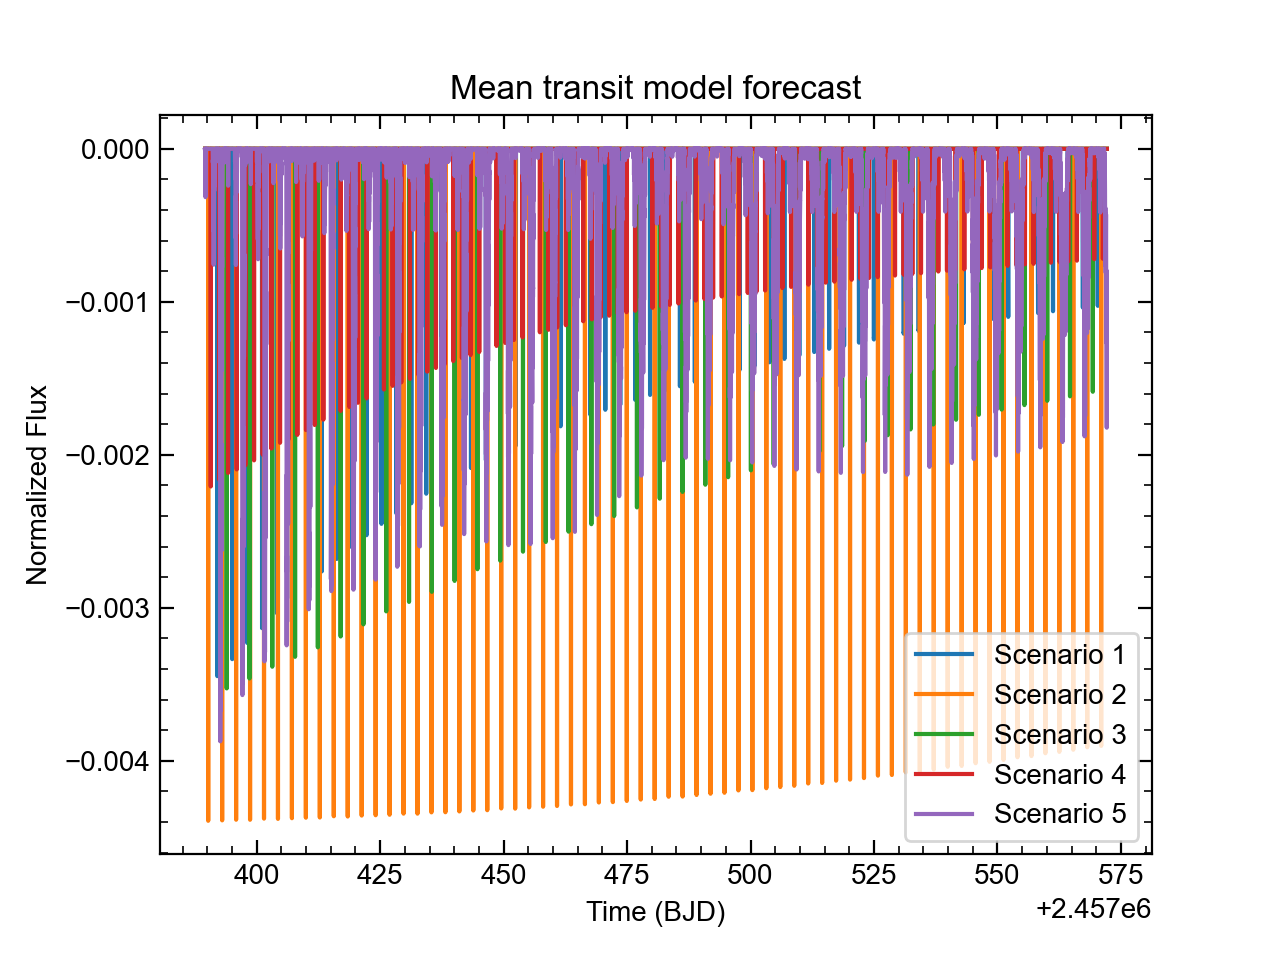

In [16]:
fig, ax = plt.subplots()
for i, forecast in enumerate(forecasts):
    ax.plot(
        tforecast, forecast, color=f'C{i}', label=f'Scenario {i+1}'
    )
ax.legend()
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Normalized Flux')
ax.set_title('Mean transit model forecast');

...and a close-up to get a better sense of what's going on.

<IPython.core.display.Javascript object>


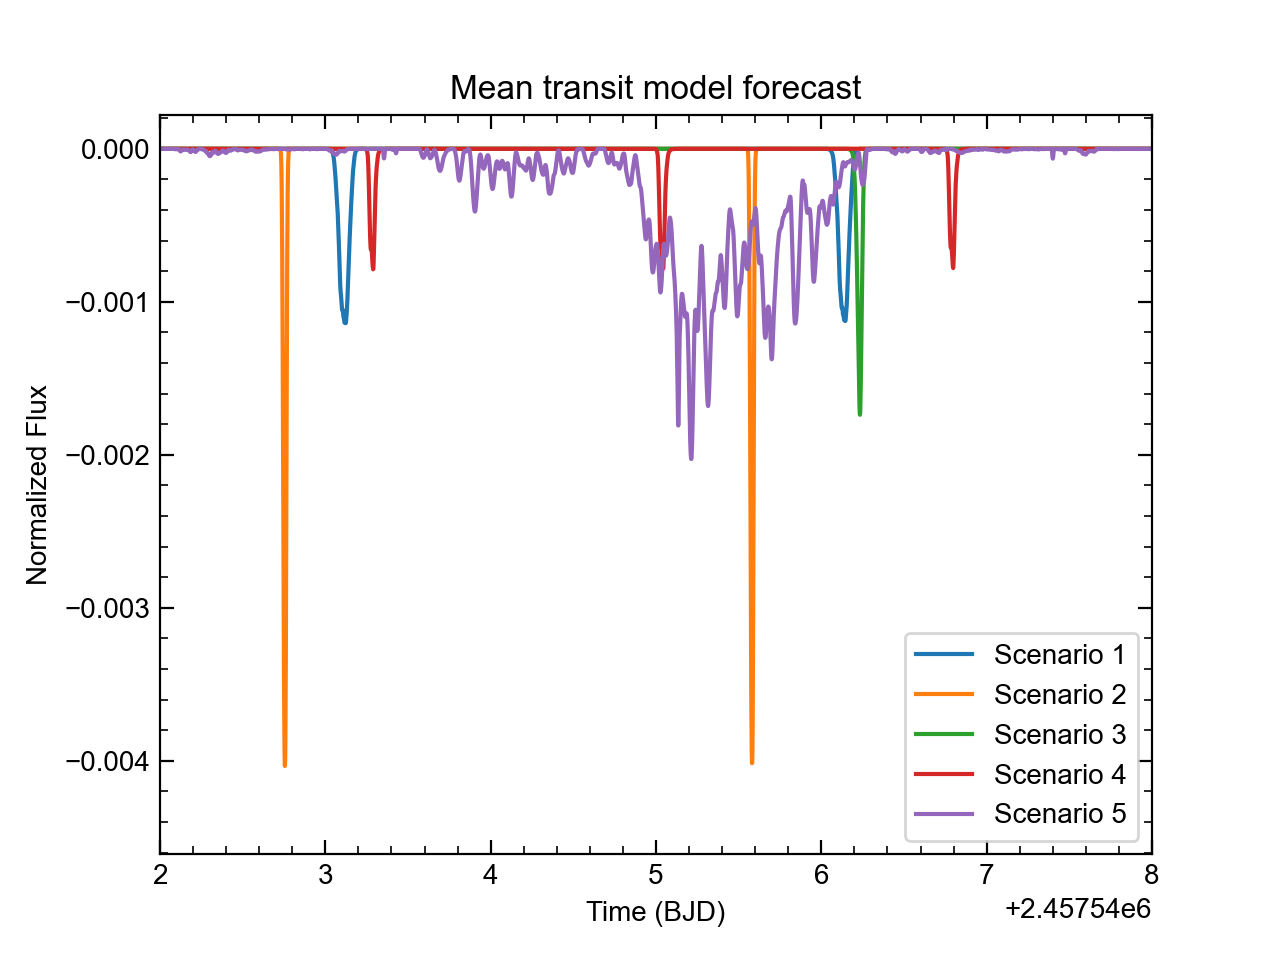

In [17]:
fig, ax = plt.subplots()
for i, forecast in enumerate(forecasts):
    ax.plot(
        tforecast, forecast, color=f'C{i}', label=f'Scenario {i+1}'
    )
ax.legend()
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Normalized Flux')
ax.set_title('Mean transit model forecast')
ax.set_xlim(2457542, 2457548);

It looks like there are relatively sharp prediction windows for Scenarios 1–4, while Scenario 5 is all over the place.

This assessment doesn't take into account how well each of these scenarios fit the data.
Scenario 5, for example, predicts relatively deep transits over a wide window because the MCMC sampling was unable to find a good solution with the priors we gave it, and so it placed arbitrarily deep transits in data gaps.

Nonetheless, let's take these forecasts at face value for now, and take a look at when we might follow-up on them.

## Identifying Follow-up Windows

We can easily identify the peaks in the forecast predictions with the `tf.summarize_windows()` function.

In [18]:
windows = [
    tf.summarize_windows(trace, tforecast) for trace in traces
]

For each scenario, we know have an `astropy.table.Table` listing the peaks in the transit forecast and the lower and upper times bounding the peak.

<IPython.core.display.Javascript object>


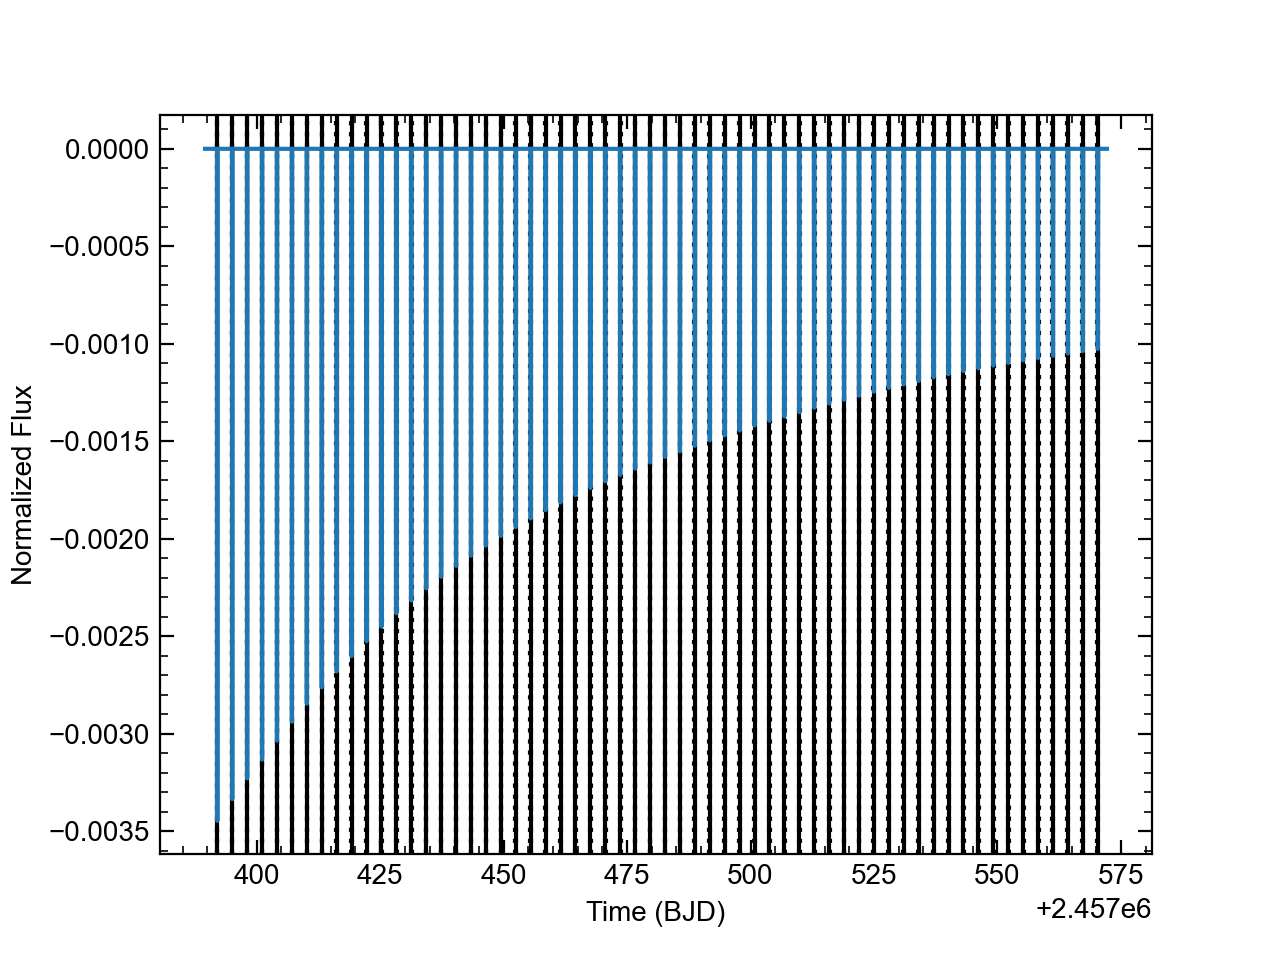

In [19]:
fig, ax = plt.subplots()

ax.plot(tforecast, forecasts[0])
for win in windows[0]:
    ax.axvline(win['median'].jd, color='k', ls='-', zorder=-1)
    ax.axvline(win['lower'].jd, color='k', ls=':', zorder=-1)
    ax.axvline(win['upper'].jd, color='k', ls=':', zorder=-1)
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Normalized Flux');

...and a close-up again:

<ipython-input-20-36c4523f1ec4>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


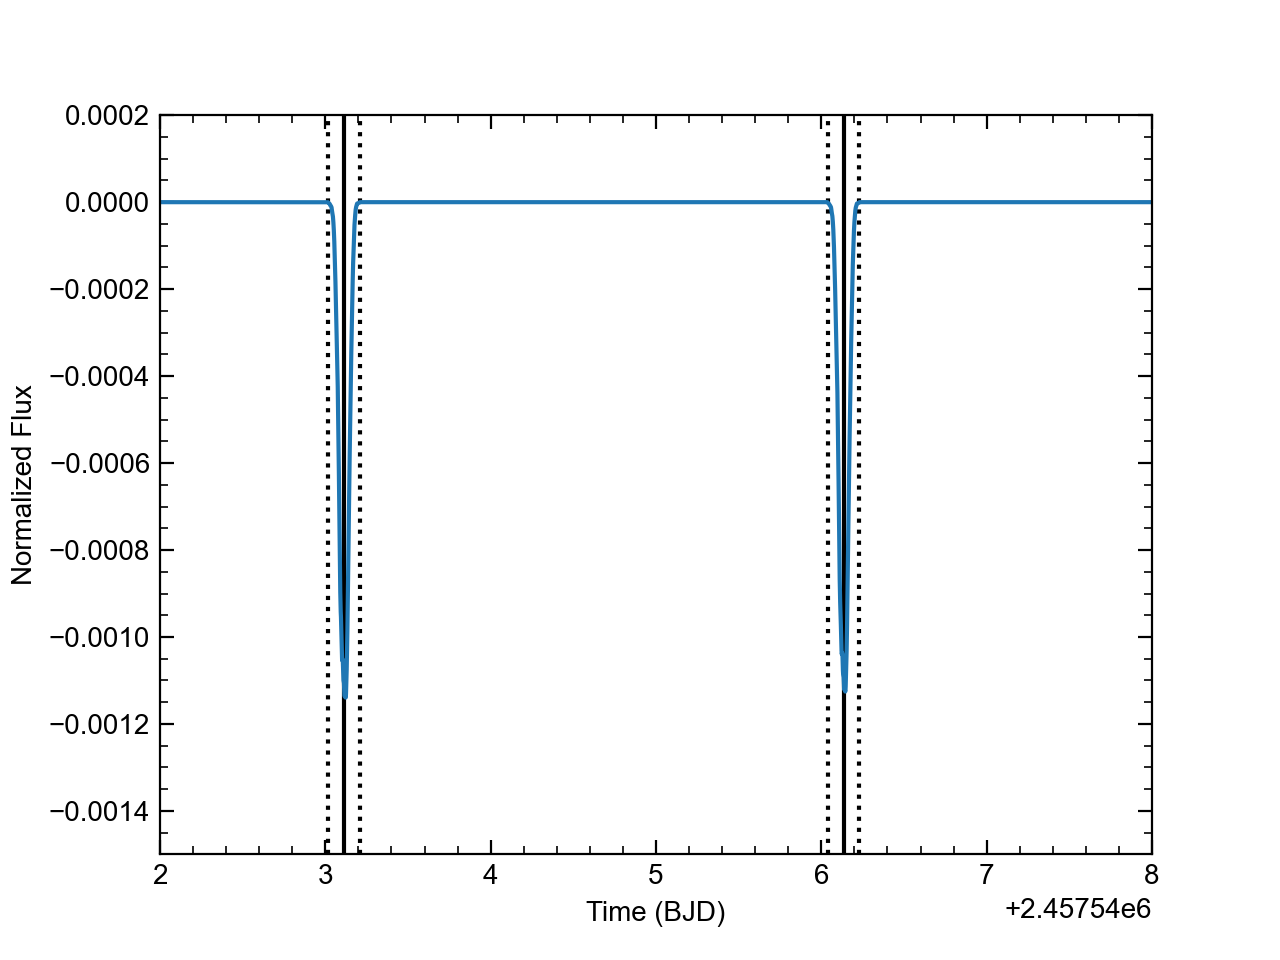

In [20]:
fig, ax = plt.subplots()

ax.plot(tforecast, forecasts[0])
for win in windows[0]:
    ax.axvline(win['median'].jd, color='k', ls='-', zorder=-1)
    ax.axvline(win['lower'].jd, color='k', ls=':', zorder=-1)
    ax.axvline(win['upper'].jd, color='k', ls=':', zorder=-1)
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Normalized Flux')
ax.set_ylim(-0.0015, 0.0002)
ax.set_xlim(2457542, 2457548);

With these forecasts, there are a few ways we can priotize follow-up windows.

### What scenarios are best for follow-up generally?

The first thing we should consider is that not all of these predictions are equally good: from the posterior models plotted above, it seems Scenarios 1 and 2 correspond to actual transiting planets (or aliases or their peirods), while Scenario 5 failed to key in on anything and the algorithm just placed a bunch of transits in the gaps between the data.

For this reason, we define weights $w_{i}$ for the tested scenarios using the p-values corresponding to the $\chi^2$ value for their median posterior model.

In [21]:
weights = tf.relative_weights(lc, traces)
weights

array([0.73965477, 0.21844481, 0.02460692, 0.01443245, 0.00286105])

Indeed, Scenarios 1 and 2 are strongly weighted over the others, and we should focus follow-up efforts on these (first) to maximize planet detections.

### What events represent the best use of telescope time?

The other aspect we should keep in mind is that later event and some scenarios (with looser period constraints) lead to wider prediction windows.
So it's possible that focusing on a given scenario or predicted event will ultimately be a more productive use of telescope time.

To take all of this into account, we define the fraction of the transit signal within the window $\Delta t \in [t_{l}, t_{u}]$ covered by an observation spanning $[t_{1}, t_{2}]$ as

$f = \frac{\int_{t_{1}}^{t_{2}} \mathcal{F} dt}
          {\int_{t_{l}}^{t_{u}} \mathcal{F} dt}$

and the observational efficiency metric $M$ as 

$M = \frac{w f}
          {t_{2}-t_{1}}$.

The metric prioritizes scenarios with higher weights, observations that cover larger fractions of the predicted signal, and observations that take less telescope time.

To calculate $f$ we need to have an observing site in mind.
We'll define our site, our observing constraints, and the position of our object in the sky with `astroplan`.

In [22]:
import astroplan as ap
from astropy.coordinates import SkyCoord
from astropy.time import Time

# Constraints
constraints = [
    ap.AtNightConstraint.twilight_civil(),
    ap.AltitudeConstraint(min=30.*units.deg),
    ap.MoonSeparationConstraint(min=30.*units.deg)
]

# Sites
sno = ap.Observer(
    longitude=-16.5097*units.deg, latitude=28.3*units.deg,
    elevation=2390*units.m, name='sno', timezone='Atlantic/Canary'
)
sso = ap.Observer.at_site('Paranal', name='sso')
saintex = ap.Observer.at_site(
    'Observatorio Astronomico Nacional, San Pedro Martir',
    name='saintex'
)
sites = [sno, sso, saintex]

# Target
target = ap.FixedTarget.from_name('TRAPPIST-1')

Now, we'll caculate the observable windows for each of the scenarios from SSO.

In [23]:
site = sso
obs_windows = []
for i, window in enumerate(windows):
    forecast = forecasts[i]
    weight = weights[i]
    obs_window = tf.observable_windows(
        window, tforecast, forecast, target, site, constraints, weight
    )
    obs_windows.append(obs_window)

We can quickly see what the best events are by taking a look at the $M$ values.

<ipython-input-24-98f92edc3b41>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


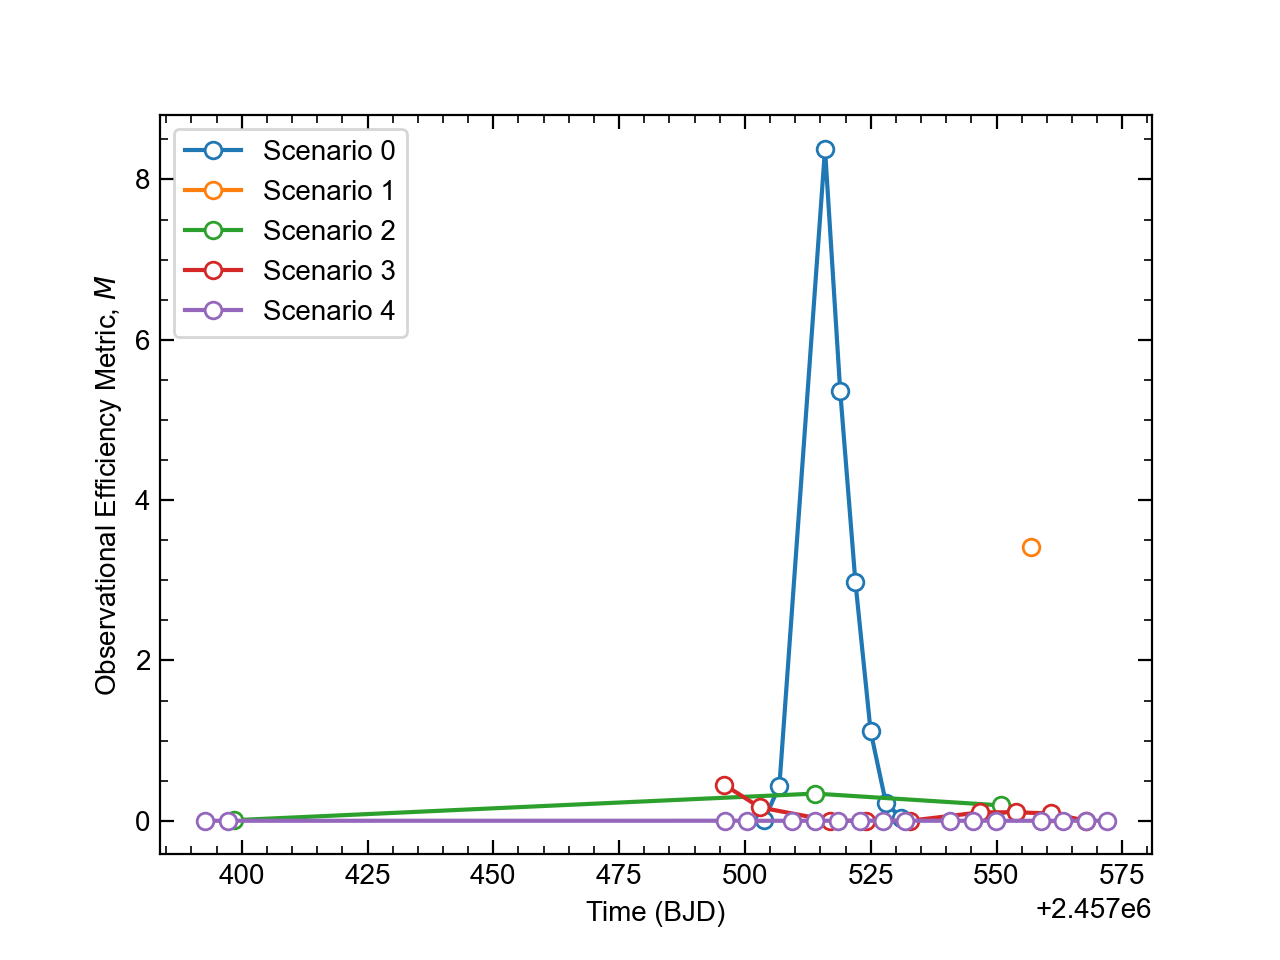

In [24]:
fig, ax = plt.subplots()

for i, win in enumerate(obs_windows):
    ax.plot(win['median'].jd, win['M'], marker='o', color=f'C{i}', mfc='white', label=f'Scenario {i}')

ax.legend(loc='upper left')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Observational Efficiency Metric, $M$');

It looks like there are a handful of observable window for Scenario 1 and maybe one for Scenario 2.

In [25]:
obs_windows[0].to_pandas()

median                         lower  \
0 2016-04-25 07:54:02.169083655 2016-04-25 05:58:03.072008193   
1 2016-04-28 08:25:35.712866485 2016-04-28 06:28:03.072021604   
2 2016-05-07 10:00:16.784405708 2016-05-07 07:56:03.072028756   
3 2016-05-10 10:31:50.389222205 2016-05-10 08:26:03.072001934   
4 2016-05-13 11:03:23.873741627 2016-05-13 08:56:03.072015345   
5 2016-05-16 11:34:57.452004254 2016-05-16 09:26:03.072028756   
6 2016-05-19 12:06:31.104698181 2016-05-19 09:54:03.072009087   
7 2016-05-22 12:38:04.799797833 2016-05-22 10:24:03.072022498   

                          upper                            t1  \
0 2016-04-25 09:46:03.071997464 2016-04-25 09:38:03.072026074   
1 2016-04-28 10:20:03.071996570 2016-04-28 09:26:03.072028756   
2 2016-05-07 11:58:03.072008193 2016-05-07 08:50:03.071996570   
3 2016-05-10 12:32:03.072007298 2016-05-10 08:38:03.071999252   
4 2016-05-13 13:06:03.072006404 2016-05-13 08:56:03.072015345   
5 2016-05-16 13:38:03.072012663 2016-05-16 09:26:03.072028756   
6 2016-05-19 14:12:03.072011769 2016-05-19 09:54:03.072009087   
7 2016-05-22 14:46:03.072010875 2016-05-22 10:24:03.072022498   

                             t2        dt  fraction         M  
0 2016-04-25 09:46:03.071997464  0.005556  0.000077  0.010311  
1 2016-04-28 10:20:03.071996570  0.037500  0.022184  0.437558  
2 2016-05-07 10:42:03.071998358  0.077778  0.881416  8.382135  
3 2016-05-10 10:44:03.072031438  0.087500  0.633717  5.356937  
4 2016-05-13 10:44:03.072031438  0.075000  0.301813  2.976503  
5 2016-05-16 10:46:03.072024286  0.055556  0.083821  1.115981  
6 2016-05-19 10:48:03.072017133  0.037500  0.011385  0.224566  
7 2016-05-22 10:48:03.072017133  0.016667  0.000840  0.037271

In [26]:
obs_windows[1].to_pandas()

median                         lower  \
0 2016-06-17 09:10:53.310075402 2016-06-17 08:26:03.072001934   

                          upper                            t1  \
0 2016-06-17 09:58:03.071994781 2016-06-17 08:26:03.072001934   

                             t2        dt  fraction         M  
0 2016-06-17 09:58:03.071994781  0.063889       1.0  3.419136

In [27]:
obs_windows[2].to_pandas()

median                         lower  \
0 2016-01-11 00:49:13.204058111 2016-01-11 00:04:03.072026968   
1 2016-05-05 10:08:25.189360678 2016-05-05 08:42:03.072025180   
2 2016-06-11 08:19:23.191089034 2016-06-11 06:40:03.072018921   

                          upper                            t1  \
0 2016-01-11 01:32:03.071993887 2016-01-11 00:04:03.072026968   
1 2016-05-05 11:22:03.072016239 2016-05-05 08:58:03.072008193   
2 2016-06-11 09:44:03.072004616 2016-06-11 06:40:03.072018921   

                             t2        dt  fraction         M  
0 2016-01-11 00:24:03.071995676  0.013889  0.004384  0.007768  
1 2016-05-05 10:40:03.072005510  0.070833  0.977488  0.339571  
2 2016-06-11 09:44:03.072004616  0.127778  1.000000  0.192576

In [28]:
obs_windows[3].to_pandas()

median                         lower  \
0 2016-04-17 10:15:57.034103572 2016-04-17 09:10:03.072005510   
1 2016-04-24 10:38:49.041829705 2016-04-24 09:30:03.072014451   
2 2016-05-08 11:24:33.707167804 2016-05-08 10:12:03.072025180   
3 2016-05-15 11:47:25.927566290 2016-05-15 10:32:03.071993887   
4 2016-05-24 06:16:01.739784479 2016-05-24 04:58:03.072021604   
5 2016-06-07 07:01:46.144210696 2016-06-07 05:38:03.071999252   
6 2016-06-14 07:24:38.305788338 2016-06-14 05:58:03.072008193   
7 2016-06-21 07:47:30.605084002 2016-06-21 06:20:03.072009981   
8 2016-06-28 08:10:23.037430644 2016-06-28 06:40:03.072018921   

                          upper                            t1  \
0 2016-04-17 12:00:03.072001040 2016-04-17 10:10:03.072032332   
1 2016-04-24 12:26:03.072028756 2016-04-24 09:42:03.072011769   
2 2016-05-08 13:18:03.072003722 2016-05-08 10:12:03.072025180   
3 2016-05-15 13:46:03.072024286 2016-05-15 10:32:03.071993887   
4 2016-05-24 08:18:03.072030544 2016-05-24 07:44:03.072031438   
5 2016-06-07 09:12:03.071998358 2016-06-07 06:48:03.072030544   
6 2016-06-14 09:38:03.072026074 2016-06-14 06:22:03.072002828   
7 2016-06-21 10:06:03.072006404 2016-06-21 06:20:03.072009981   
8 2016-06-28 10:32:03.071993887 2016-06-28 10:10:03.072032332   

                             t2        dt  fraction         M  
0 2016-04-17 10:34:03.072026968  0.016667  0.517513  0.448138  
1 2016-04-24 10:36:03.072019815  0.037500  0.436740  0.168086  
2 2016-05-08 10:42:03.071998358  0.020833  0.001383  0.000958  
3 2016-05-15 10:46:03.072024286  0.009722  0.000149  0.000221  
4 2016-05-24 08:18:03.072030544  0.023611  0.000969  0.000592  
5 2016-06-07 09:12:03.071998358  0.100000  0.734736  0.106040  
6 2016-06-14 09:38:03.072026074  0.136111  0.999782  0.106011  
7 2016-06-21 10:06:03.072006404  0.156944  1.000000  0.091959  
8 2016-06-28 10:32:03.071993887  0.015278  0.000315  0.000298

In [29]:
obs_windows[4].to_pandas()

median                         lower  \
0  2016-01-05 05:13:58.317373395 2016-01-03 04:56:03.072028756   
1  2016-01-09 16:57:48.201130629 2016-01-07 13:30:03.072001040   
2  2016-04-17 10:56:18.918573260 2016-04-15 02:36:03.072006404   
3  2016-04-21 22:39:37.912777662 2016-04-19 14:20:03.072023392   
4  2016-04-30 22:06:49.917940199 2016-04-28 13:42:03.071998358   
5  2016-05-05 09:51:17.114872634 2016-05-03 01:24:03.072022498   
6  2016-05-09 21:36:01.162970960 2016-05-07 13:06:03.072006404   
7  2016-05-14 09:19:56.282427013 2016-05-12 00:48:03.072030544   
8  2016-05-18 21:03:30.923901200 2016-05-16 12:30:03.072014451   
9  2016-05-23 08:46:45.407407880 2016-05-21 00:12:03.071998358   
10 2016-06-01 08:17:53.146234453 2016-05-29 23:34:03.072013557   
11 2016-06-05 20:01:10.249079168 2016-06-03 11:18:03.072030544   
12 2016-06-10 07:44:40.319988728 2016-06-07 23:00:03.072014451   
13 2016-06-19 07:10:47.093962133 2016-06-16 22:22:03.072029650   
14 2016-06-23 18:50:43.095423281 2016-06-21 10:04:03.072013557   
15 2016-06-28 06:32:12.224160433 2016-06-25 21:46:03.071997464   
16 2016-07-02 10:30:01.300375164 2016-06-30 09:28:03.072021604   

                           upper                            t1  \
0  2016-01-07 01:04:03.072013557 2016-01-04 00:02:03.071993887   
1  2016-01-11 22:14:03.072018027 2016-01-08 00:02:03.071993887   
2  2016-04-19 14:16:03.071997464 2016-04-15 10:18:03.072003722   
3  2016-04-24 02:00:03.072014451 2016-04-20 09:58:03.071994781   
4  2016-05-03 01:22:03.072029650 2016-04-29 09:22:03.072002828   
5  2016-05-07 13:04:03.072013557 2016-05-05 08:58:03.072008193   
6  2016-05-12 00:46:03.071997464 2016-05-08 08:46:03.072010875   
7  2016-05-16 12:28:03.072021604 2016-05-12 08:32:03.072020710   
8  2016-05-21 00:10:03.072005510 2016-05-17 08:12:03.072011769   
9  2016-05-25 11:52:03.072029650 2016-05-21 07:56:03.072028756   
10 2016-06-03 11:14:03.072004616 2016-06-01 07:12:03.072025180   
11 2016-06-07 22:58:03.072021604 2016-06-04 07:00:03.072027862   
12 2016-06-12 10:40:03.072005510 2016-06-08 06:44:03.072004616   
13 2016-06-21 10:02:03.072020710 2016-06-17 06:10:03.072005510   
14 2016-06-25 21:44:03.072004616 2016-06-21 10:04:03.072013557   
15 2016-06-30 09:26:03.072028756 2016-06-28 10:10:03.072032332   
16 2016-07-02 16:02:03.072020710 2016-06-30 09:28:03.072021604   

                              t2        dt  fraction         M  
0  2016-01-07 00:40:03.072018921  3.026389  0.042346  0.000040  
1  2016-01-11 00:24:03.071995676  3.015278  0.453680  0.000430  
2  2016-04-19 10:34:03.072026968  4.011111  1.320944  0.000942  
3  2016-04-23 10:36:03.072019815  3.026389  0.640823  0.000606  
4  2016-04-30 10:38:03.072012663  1.052778  0.050620  0.000138  
5  2016-05-07 10:42:03.071998358  2.072222  0.589017  0.000813  
6  2016-05-11 10:44:03.072031438  3.081944  0.961680  0.000893  
7  2016-05-16 10:46:03.072024286  4.093056  1.112021  0.000777  
8  2016-05-20 10:48:03.072017133  3.108333  1.095603  0.001008  
9  2016-05-25 10:50:03.072009981  4.120833  1.057946  0.000735  
10 2016-06-03 10:54:03.071995676  2.154167  0.364062  0.000484  
11 2016-06-07 10:56:03.072028756  3.163889  0.898511  0.000813  
12 2016-06-12 10:40:03.072005510  4.163889  0.819620  0.000563  
13 2016-06-21 10:02:03.072020710  4.161111  0.936726  0.000644  
14 2016-06-23 11:00:03.072014451  2.038889  0.249219  0.000350  
15 2016-06-30 09:26:03.072028756  1.969444  0.401947  0.000584  
16 2016-07-02 11:00:03.072014451  2.063889  0.695331  0.000964

### Identifying the best site for follow-up

We can repeat the above exercise for multiple sites to identify the best site to catch a good follow-up window.

In [30]:
obs_dict = {}
for site in sites:
    obs_windows = []   
    for i, window in enumerate(windows):
        forecast = forecasts[i]
        weight = weights[i]
        obs_window = tf.observable_windows(
            window, tforecast, forecast, target, site, constraints, weight
        )
        obs_windows.append(obs_window)
    obs_dict[site.name] = obs_windows

Let's visualize the results.

<ipython-input-31-c5c798781594>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6.5, 4))


<IPython.core.display.Javascript object>


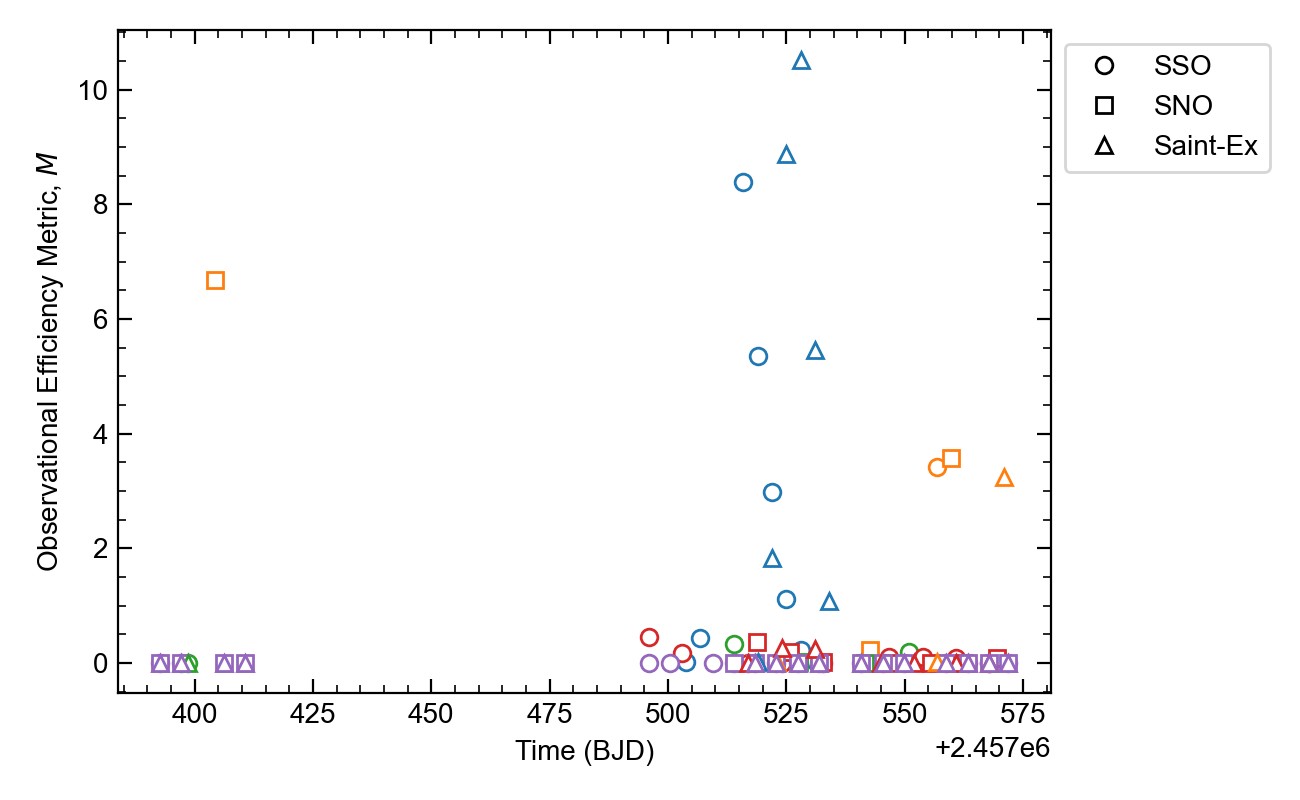

In [31]:
obs_sno = obs_dict['sno']
obs_sso = obs_dict['sso']
obs_saintex = obs_dict['saintex']

fig, ax = plt.subplots(figsize=(6.5, 4))

for i, win in enumerate(obs_sso):
    ax.plot(win['median'].jd, win['M'], marker='o', ls='', color=f'C{i}', mfc='white')
for i, win in enumerate(obs_sno):
    ax.plot(win['median'].jd, win['M'], marker='s', ls='', color=f'C{i}', mfc='white')
for i, win in enumerate(obs_saintex):
    ax.plot(win['median'].jd, win['M'], marker='^', ls='', color=f'C{i}', mfc='white')

    
# Hack a legend
ax.plot([], [], 'ko', mfc='white', label='SSO')
ax.plot([], [], 'ks', mfc='white', label='SNO')
ax.plot([], [], 'k^', mfc='white', label='Saint-Ex')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Observational Efficiency Metric, $M$')
plt.tight_layout()

Looks like there were a few high-TPM events (corresponding to Scenarios 1 and 2) and lots of low-TPM events that these faciltiies could have followed up in the first 6 months after the detection of TRAPPIST-1. The only problem is that none of them existed yet!